In [1]:
import pandas as pd
import numpy as np

import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

from wordcloud import WordCloud

# Gensim
import gensim
import gensim.corpora as corpora
# from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# t-SNE and Bokeh vis
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

# Progress bar
from tqdm.notebook import tqdm

# Word Counter
from collections import Counter


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pprint
pp = pprint.PrettyPrinter(indent=4)
import scipy.stats as ss
import itertools

c:\Users\Acer\OneDrive - Newcastle University\Work\CSC8639 - Thesis\MLTC-clustering-main\mltc\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


# Pre-Processing and analsysis

In [2]:
LTC_BINARY = '../data/ltc_matrix_binary_mm4.tsv'

ltc_patients = pd.read_csv(LTC_BINARY, sep = '\t')

ltc_patients.head(5)


patient_id  dermatitis  erectile_dysfunction  OA  pri_skin  skin_ulcer  \
0     1000059           1                     1   1         1           1   
1     1000062           0                     0   0         0           0   
2     1000077           0                     0   0         1           0   
3     1000124           0                     0   1         0           0   
4     1000146           0                     0   1         1           0   

   female_genital_prolapse  fracture_hip  obesity  spondylosis  ...  \
0                        0             0        0            0  ...   
1                        1             1        1            1  ...   
2                        0             0        0            0  ...   
3                        0             0        0            0  ...   
4                        0             0        0            0  ...   

   cerebral_palsy  pri_mesothelioma  pri_brain  thala  sick_sinus  ADHD  \
0               0                 0          0      0           0     0   
1               0                 0          0      0           0     0   
2               0                 0          0      0           0     0   
3               0                 0          0      0           0     0   
4               0                 0          0      0           0     0   

   juv_arth  downs  entero_arthro  SARS_CoV2  
0         0      0              0          0  
1         0      0              0          0  
2         0      0              0          0  
3         0      0              0          0  
4         0      0              0          0  

[5 rows x 204 columns]

In [3]:
df_col = ltc_patients.iloc[:,1:]
df_col = list(df_col.columns)
df_col

['dermatitis',
 'erectile_dysfunction',
 'OA',
 'pri_skin',
 'skin_ulcer',
 'female_genital_prolapse',
 'fracture_hip',
 'obesity',
 'spondylosis',
 'type_2_diabetes',
 'unspecified_rare_diabetes',
 'urine_incont',
 'allergic_rhinitis',
 'atrial_fibrilation',
 'cholelithiasis',
 'CKD',
 'cystic_renal',
 'enthesopathy',
 'epilepsy',
 'ESRD',
 'gout',
 'hearing_loss',
 'hypertension',
 'pri_other',
 'thyroid',
 'venous_thromb',
 'constipation_read',
 'depression',
 'intervert_disc',
 'menorrhagia',
 'CCD',
 'diab_eye',
 'periph_neuro',
 'BPH',
 'pancreatitis',
 'alcohol_depend',
 'gastritis_duodenitis',
 'infection_bones_joints',
 'osteoporosis',
 'asthma',
 'female_infertility',
 'COPD',
 'diverticular',
 'irritable_bowel_syndrome',
 'somatoform',
 'folate_deficiency',
 'retinal_detach',
 'Subarach',
 'subdural_haem',
 'chronic_fatigue',
 'vitb12_deficiency',
 'cerebrovascular_dz',
 'diab_neuro',
 'NAFLD_NASH',
 'spinal_stenosis',
 'type_1_diabetes',
 'CHD',
 'hyposplenism',
 'myeloma',

In [4]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


cols = df_col
corrM = np.zeros((len(cols),len(cols)))
# there's probably a nice pandas way to do this
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(ltc_patients[col1], ltc_patients[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)

In [ ]:
# corr = pd.read_csv('../data/corr_table.csv')

In [13]:
corr = corr.set_index('Unnamed: 0')
corr.head()

dermatitis  erectile_dysfunction        OA  pri_skin  \
Unnamed: 0                                                                   
dermatitis              0.000000              0.007238  0.017415  0.004171   
erectile_dysfunction    0.007238              0.000000  0.000000  0.016729   
OA                      0.017415              0.000000  0.000000  0.014754   
pri_skin                0.004171              0.016729  0.014754  0.000000   
skin_ulcer              0.324643              0.000000  0.010515  0.007991   

                      skin_ulcer  female_genital_prolapse  fracture_hip  \
Unnamed: 0                                                                
dermatitis              0.324643                 0.010382      0.000000   
erectile_dysfunction    0.000000                 0.099360      0.003057   
OA                      0.010515                 0.055249      0.006739   
pri_skin                0.007991                 0.006803      0.000000   
skin_ulcer              0.000000                 0.007828      0.004716   

                       obesity  spondylosis  type_2_diabetes  ...  \
Unnamed: 0                                                    ...   
dermatitis            0.005823     0.018189         0.034775  ...   
erectile_dysfunction  0.019042     0.006538         0.206477  ...   
OA                    0.068590     0.124963         0.020640  ...   
pri_skin              0.031749     0.004321         0.021182  ...   
skin_ulcer            0.021274     0.009220         0.008249  ...   

                      cerebral_palsy  pri_mesothelioma  pri_brain     thala  \
Unnamed: 0                                                                    
dermatitis                  0.000000          0.000446   0.005521  0.000000   
erectile_dysfunction        0.003688          0.002546   0.001566  0.000000   
OA                          0.000000          0.000000   0.003864  0.001871   
pri_skin                    0.000000          0.004255   0.006350  0.005755   
skin_ulcer                  0.000000          0.000000   0.000000  0.000000   

                      sick_sinus      ADHD  juv_arth     downs  entero_arthro  \
Unnamed: 0                                                                      
dermatitis              0.000000  0.003570  0.000000  0.000000       0.000000   
erectile_dysfunction    0.000000  0.001625  0.001923  0.002839       0.000000   
OA                      0.006863  0.004728  0.001827  0.003516       0.002524   
pri_skin                0.001753  0.001254  0.000000  0.000000       0.000000   
skin_ulcer              0.000000  0.000000  0.000000  0.000000       0.003689   

                      SARS_CoV2  
Unnamed: 0                       
dermatitis                  0.0  
erectile_dysfunction        0.0  
OA                          0.0  
pri_skin                    0.0  
skin_ulcer                  0.0  

[5 rows x 203 columns]

Text(0.5, 1.0, 'Cramer V Correlation between Variables')

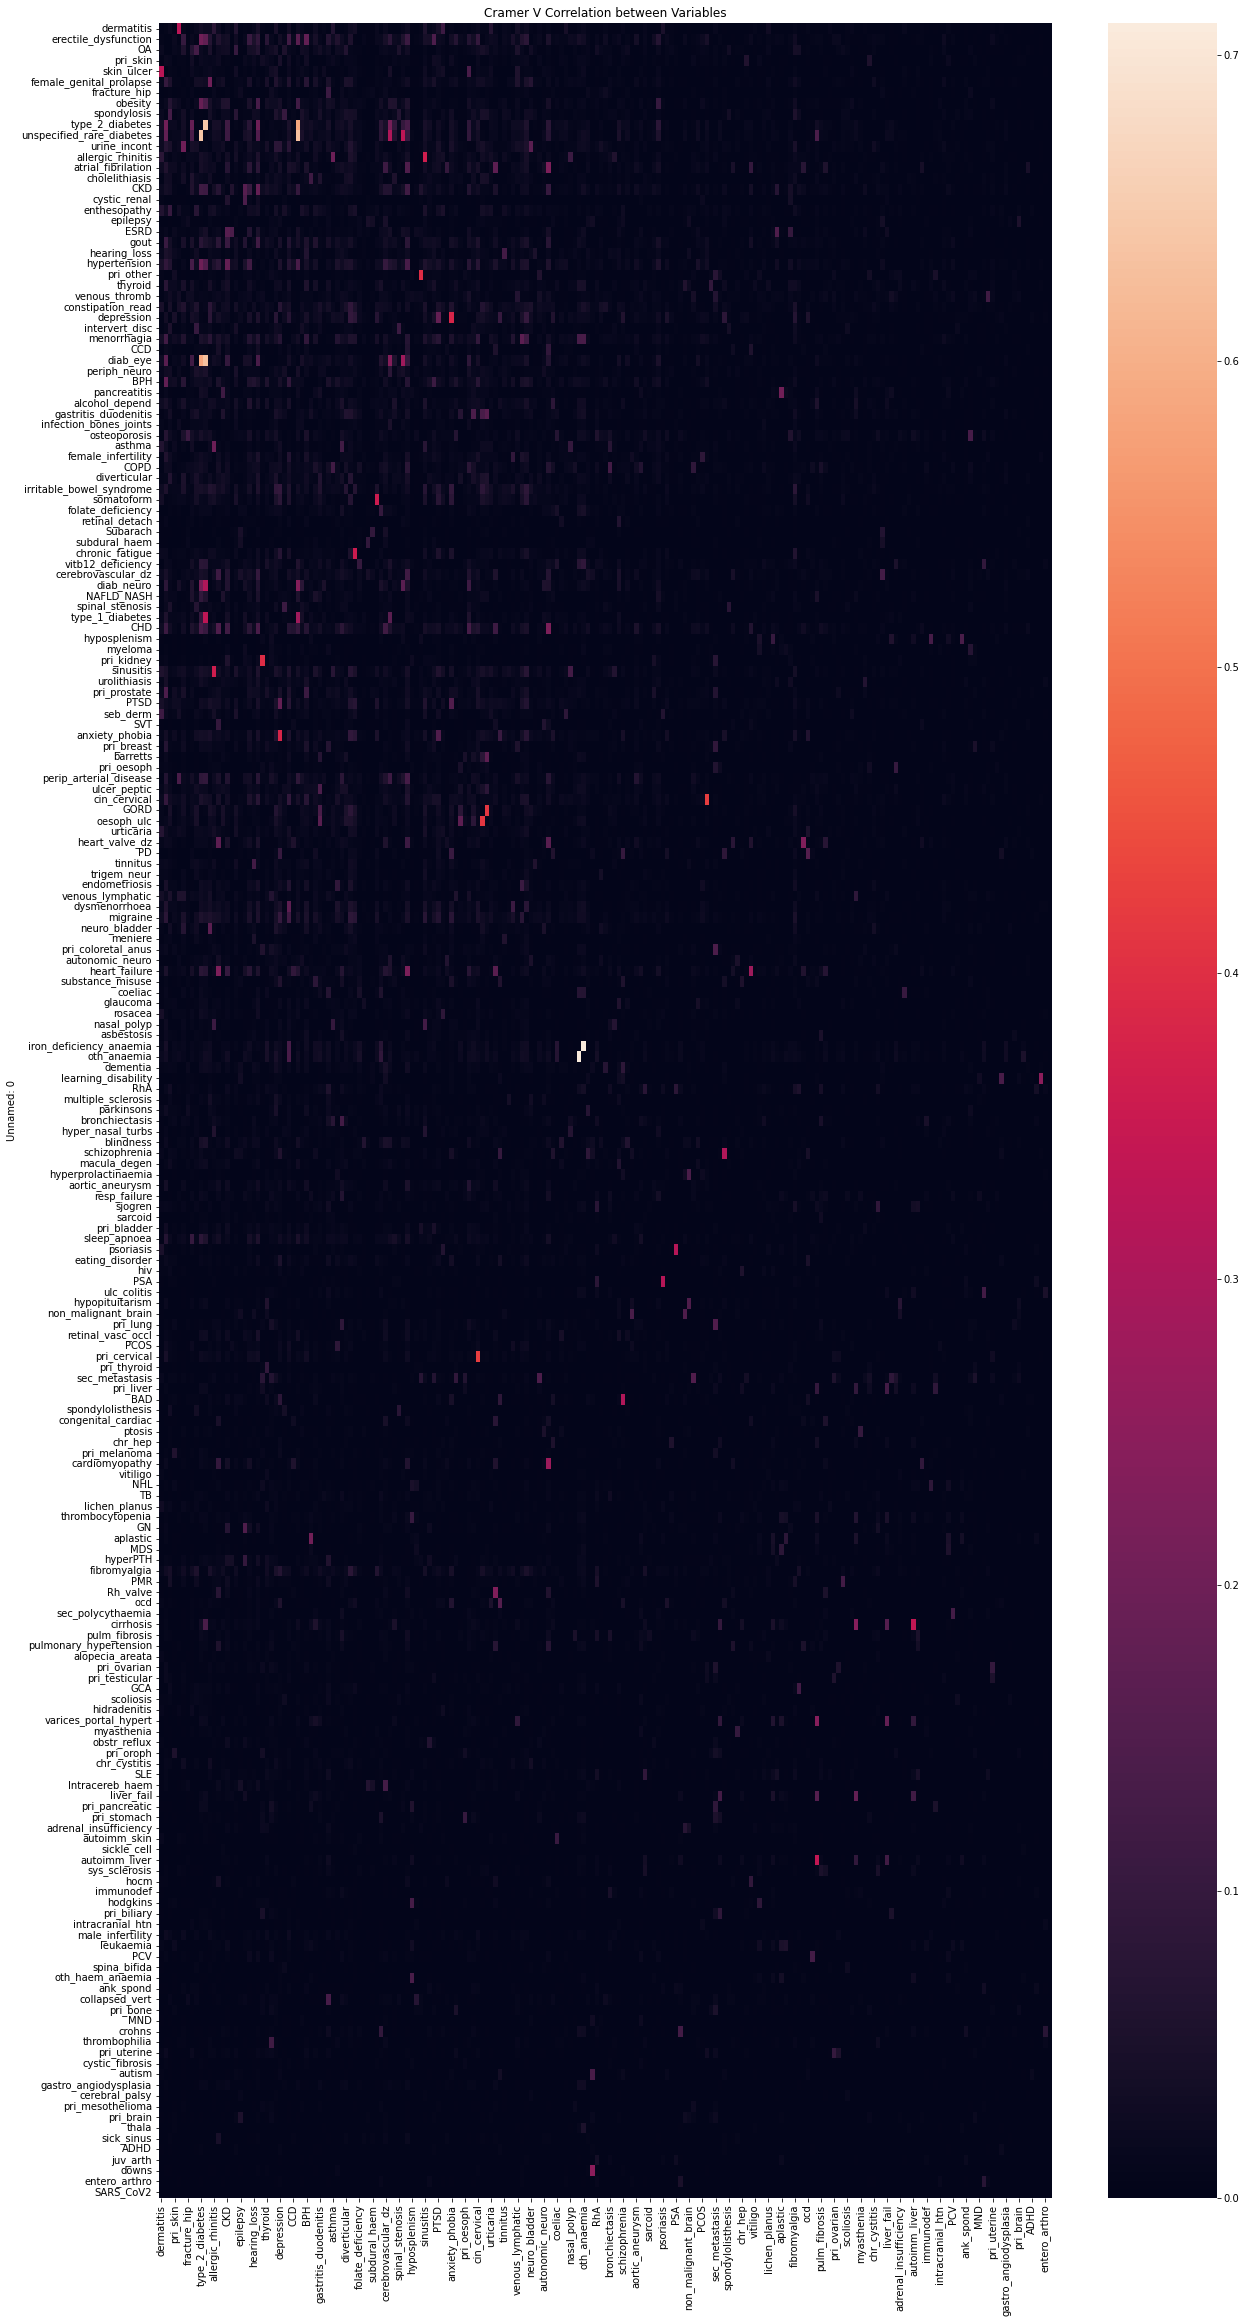

In [14]:
fig, ax = plt.subplots(figsize=(20, 40))
ax = sns.heatmap(corr, annot=False, ax=ax); ax.set_title("Cramer V Correlation between Variables")

In [6]:
corr
# corr.to_csv("corr_table.csv")

dermatitis  erectile_dysfunction        OA  pri_skin  \
dermatitis              0.000000              0.007238  0.017415  0.004171   
erectile_dysfunction    0.007238              0.000000  0.000000  0.016729   
OA                      0.017415              0.000000  0.000000  0.014754   
pri_skin                0.004171              0.016729  0.014754  0.000000   
skin_ulcer              0.324643              0.000000  0.010515  0.007991   
...                          ...                   ...       ...       ...   
ADHD                    0.003570              0.001625  0.004728  0.001254   
juv_arth                0.000000              0.001923  0.001827  0.000000   
downs                   0.000000              0.002839  0.003516  0.000000   
entero_arthro           0.000000              0.000000  0.002524  0.000000   
SARS_CoV2               0.000000              0.000000  0.000000  0.000000   

                      skin_ulcer  female_genital_prolapse  fracture_hip  \
dermatitis              0.324643                 0.010382      0.000000   
erectile_dysfunction    0.000000                 0.099360      0.003057   
OA                      0.010515                 0.055249      0.006739   
pri_skin                0.007991                 0.006803      0.000000   
skin_ulcer              0.000000                 0.007828      0.004716   
...                          ...                      ...           ...   
ADHD                    0.000000                 0.000000      0.000000   
juv_arth                0.000000                 0.000000      0.000000   
downs                   0.000000                 0.000000      0.000000   
entero_arthro           0.003689                 0.000000      0.000000   
SARS_CoV2               0.000000                 0.000000      0.000000   

                       obesity  spondylosis  type_2_diabetes  ...  \
dermatitis            0.005823     0.018189         0.034775  ...   
erectile_dysfunction  0.019042     0.006538         0.206477  ...   
OA                    0.068590     0.124963         0.020640  ...   
pri_skin              0.031749     0.004321         0.021182  ...   
skin_ulcer            0.021274     0.009220         0.008249  ...   
...                        ...          ...              ...  ...   
ADHD                  0.000000     0.003631         0.006190  ...   
juv_arth              0.000000     0.001675         0.000000  ...   
downs                 0.000000     0.002694         0.000000  ...   
entero_arthro         0.000000     0.000000         0.003184  ...   
SARS_CoV2             0.000000     0.000000         0.000000  ...   

                      cerebral_palsy  pri_mesothelioma  pri_brain     thala  \
dermatitis                  0.000000          0.000446   0.005521  0.000000   
erectile_dysfunction        0.003688          0.002546   0.001566  0.000000   
OA                          0.000000          0.000000   0.003864  0.001871   
pri_skin                    0.000000          0.004255   0.006350  0.005755   
skin_ulcer                  0.000000          0.000000   0.000000  0.000000   
...                              ...               ...        ...       ...   
ADHD                        0.000000          0.000000   0.000000  0.000000   
juv_arth                    0.000000          0.000000   0.000000  0.000000   
downs                       0.000000          0.000000   0.000000  0.000000   
entero_arthro               0.000000          0.000000   0.000000  0.000000   
SARS_CoV2                   0.000000          0.000000   0.000000  0.000000   

                      sick_sinus      ADHD  juv_arth     downs  entero_arthro  \
dermatitis              0.000000  0.003570  0.000000  0.000000       0.000000   
erectile_dysfunction    0.000000  0.001625  0.001923  0.002839       0.000000   
OA                      0.006863  0.004728  0.001827  0.003516       0.002524   
pri_skin                0.001753  0.001254  0.000000  0.000000       0.000000   
s

In [7]:
for i in corr.columns:
    if corr[i].max() >= 0.5:
        print(corr[[i]].idxmax())
        

type_2_diabetes    unspecified_rare_diabetes
dtype: object
unspecified_rare_diabetes    type_2_diabetes
dtype: object
diab_eye    unspecified_rare_diabetes
dtype: object
iron_deficiency_anaemia    oth_anaemia
dtype: object
oth_anaemia    iron_deficiency_anaemia
dtype: object


In [34]:
print(len(ltc_patients['patient_id'].unique()))
print(ltc_patients.shape)
print('Total diseases: ', len(ltc_patients.columns)-1)

143168
(143168, 204)
Total diseases:  203


In [3]:
list_of_patients = []

patients = ltc_patients['patient_id'].unique()
ltcs = ltc_patients.drop('patient_id', axis = 1)
index = 0

# Iterate through patients
for patient in patients:
    
    # Start with empty list of LTCs for each patient
    patient_ltcs = []
    
    # Iterate through each LTC for patient
    for ltc in ltcs:
        
        # Check if patient has LTC
        if ltc_patients.at[index, ltc] == 1:
            
            # If LTC present, add to list of patient LTCs
            patient_ltcs.append(ltc)   
    
    # Add list of patient LTCs to list of patients        
    list_of_patients.append(patient_ltcs)
    
    # Increment index by 1
    index+=1

In [4]:
all_len = 0

for text in list_of_patients:
    all_len += len(text)
    
avg_len = all_len/len(list_of_patients)

print("All words: {n}".format(n=all_len))
print("Average LTCs per patient: {n}".format(n=avg_len))
print("Maximum amount of LTCs: {n}".format(n= max(len(x) for x in list_of_patients)))
print("Minimum amount of LTCs: {n}".format(n= min(len(x) for x in list_of_patients)))
print("Patients in corpus: {l}".format(l=len(list_of_patients)))
print("Example of patient record:\n {n}".format(n=list_of_patients[1]))

All words: 1104514
Average LTCs per patient: 7.714810572194904
Maximum amount of LTCs: 37
Minimum amount of LTCs: 4
Patients in corpus: 143168
Example of patient record:
 ['female_genital_prolapse', 'fracture_hip', 'obesity', 'spondylosis', 'type_2_diabetes', 'unspecified_rare_diabetes', 'urine_incont']


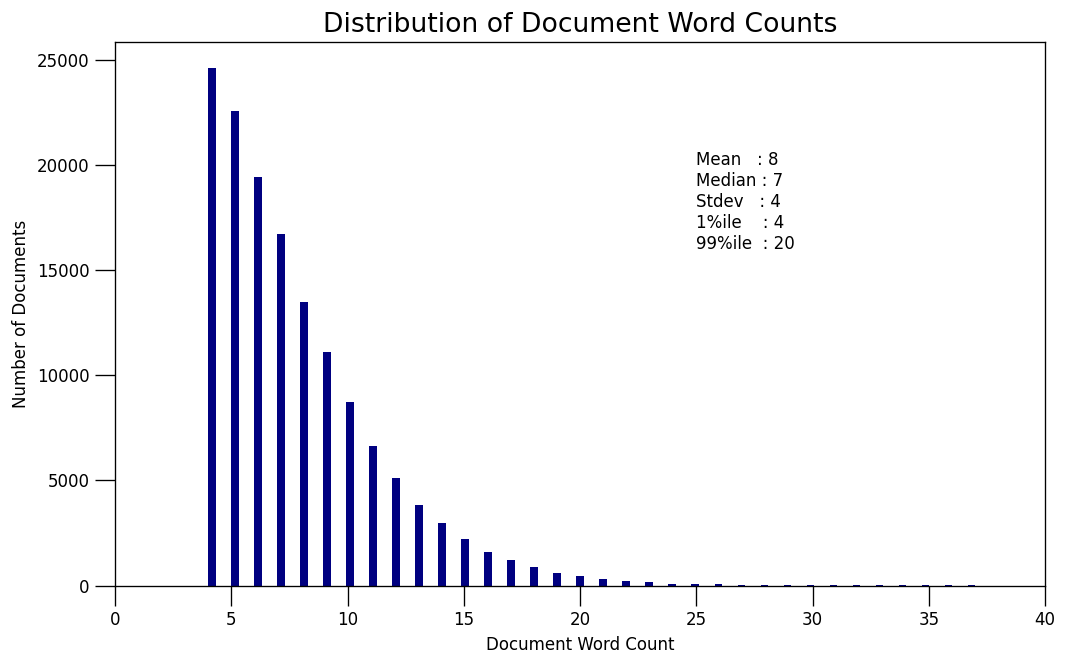

In [6]:
doc_lens = [len(d) for d in list_of_patients]

# Plot
plt.figure(figsize=(10,6), dpi=120)
plt.hist(doc_lens, bins = 100, color='navy')
plt.text(25, 20000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(25,  19000, "Median : " + str(round(np.median(doc_lens))))
plt.text(25,  18000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(25,  17000, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(25,  16000, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 40), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=12)
plt.xticks(np.linspace(0,40,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=16))
plt.show()

# 1) Implementing LDA model

In [5]:
counter_obj = Counter()
for patient in list_of_patients:

    counter_obj += Counter(patient)
    
counter_obj.most_common(10)

[('enthesopathy', 56821),
 ('hypertension', 56254),
 ('dermatitis', 48821),
 ('depression', 47258),
 ('OA', 43201),
 ('sinusitis', 35633),
 ('allergic_rhinitis', 33200),
 ('anxiety_phobia', 28987),
 ('hearing_loss', 25926),
 ('GORD', 24745)]

In [6]:
id2word = corpora.Dictionary(list_of_patients)

corpus = []
for text in list_of_patients:
    new = id2word.doc2bow(text)
    corpus.append(new)

In [6]:
print(corpus[202][0:30])
print(id2word[202])

[(14, 1), (18, 1), (22, 1), (61, 1), (144, 1)]
SARS_CoV2


In [10]:
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4,
                                           workers=3,
                                           random_state=100,
                                           chunksize=500,
                                           passes=10,
                                           alpha="asymmetric",
                                           eta=1.0)

# Note: num_topics attempted: 20, 15, 10, 5, 6, ,7 , 8, 4

In [14]:
# Topic 4
text = ['depression','migraine','PTSD']
bow = id2word.doc2bow(text)

print(lda_model[bow])
# [(0, 0.10728592), (1, 0.06515038), (2, 0.7885775), (3, 0.038986254)]

[(0, 0.10735146), (1, 0.065150805), (2, 0.7885114), (3, 0.03898637)]


In [37]:
# Will store topic similarity score for each of the patients in our corpus
lda_res_each_ptnt = []
for i in list_of_patients:
    bow = id2word.doc2bow(i)
    lda_res_each_ptnt.append(lda_model[bow])

In [38]:
# lda results for each patients in a list form
lda_res_each_ptnt[0:3]

[[(0, 0.5817262), (1, 0.35965183), (2, 0.032523002), (3, 0.026099019)],
 [(0, 0.06440989), (1, 0.22459304), (2, 0.3449019), (3, 0.36609522)],
 [(0, 0.22731967), (1, 0.75067043), (2, 0.01223494)]]

In [ ]:
# Compute Coherence Score
# Baseline Coherence Score with 4 topics, alpha = symmetric, eta = None: 0.4487394554659151  - 15.6% improvement 
# Baseline Coherence Score with 5 topics, alpha = symmetric, eta = None: 0.43784169279623864 - 12.8% improvement
# Baseline Coherence Score with 6 topics, alpha = symmetric, eta = None: 0.42380960867457573 - 9.21% improvement
# Baseline Coherence Score with 6 topics, alpha = symmetric, eta = None:  - % improvement

baseline = 0.3880742386

coherence_model_lda = CoherenceModel(model=lda_model, texts=list_of_patients, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

print("{n:0.2f}% Improvement".format(n=(coherence_lda*100/baseline)-100))

# 2) Association Strength

In [16]:
# Creating a matrix of disease/MLTC/word distribution within each cluster

df_word_weightage_bytopic = pd.DataFrame(columns=['MLTC', 0,1,2,3])

for t in range(4):
    df_cal = pd.DataFrame(columns=['MLTC', t])
    nm = list()
    dst = list()
    for i in range(203):
        name, dist = lda_model.show_topics(num_words=203, formatted=False)[t][1][i]
        nm.append(name)
        dst.append(dist)
    df_cal[t] = dst
    df_cal['MLTC'] = nm
    df_cal.sort_values(by=['MLTC'], ignore_index=True, inplace=True)
    
    df_word_weightage_bytopic[t] = df_cal[t]
df_word_weightage_bytopic['MLTC'] = df_cal['MLTC']

In [17]:
df_word_weightage_bytopic

MLTC         0         1         2         3
0                     ADHD  0.000002  0.000004  0.000008  0.000927
1                      BAD  0.000002  0.000004  0.000009  0.013495
2                      BPH  0.000002  0.035414  0.000007  0.000019
3                      CCD  0.000003  0.004849  0.000008  0.000018
4                      CHD  0.000003  0.051865  0.000008  0.022601
..                     ...       ...       ...       ...       ...
198  varices_portal_hypert  0.000002  0.000004  0.000006  0.004090
199       venous_lymphatic  0.025340  0.010159  0.002748  0.000036
200          venous_thromb  0.004235  0.010436  0.000014  0.000063
201      vitb12_deficiency  0.005892  0.000069  0.000014  0.020134
202               vitiligo  0.001329  0.000008  0.000010  0.000061

[203 rows x 5 columns]

In [10]:
df_idf = df_word_weightage_bytopic.copy()

In [11]:
# Calculating word/disease frequency in our corpus

idf = []
# idf = {}

for i in df_idf['MLTC']:
    count = 0
    for k in list_of_patients:
        if i in k:
            count = count +1            
    idf.append(count)
    # idf[i] = count

df_idf['idf'] = idf

In [12]:
df_idf.head(10)

MLTC         0         1         2         3    idf
0  ADHD  0.000002  0.000004  0.000008  0.000982     71
1   BAD  0.000002  0.000004  0.000009  0.013458   1112
2   BPH  0.000002  0.035223  0.000007  0.000019   9897
3   CCD  0.000003  0.004825  0.000008  0.000018   1424
4   CHD  0.000003  0.051940  0.000008  0.022453  16044
5   CKD  0.006042  0.029023  0.000012  0.026316  13483
6  COPD  0.004716  0.014039  0.000012  0.001442   6602
7  ESRD  0.000002  0.001772  0.000007  0.001552    599
8   GCA  0.000508  0.000428  0.000030  0.000035    388
9    GN  0.000477  0.002260  0.000018  0.000031    924

In [14]:
import math

# Calculating inverse document frequency
for i in range(len(df_idf['idf'])):
    df_idf['idf'].loc[i] = math.log10(len(list_of_patients) / (df_idf['idf'].loc[i] + 1))
df_idf['relative weight 0'] = ''
df_idf['relative weight 1'] = ''
df_idf['relative weight 2'] = ''
df_idf['relative weight 3'] = ''
df_idf

C:\Users\Acer\AppData\Local\Temp\ipykernel_9532\3745697159.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_idf['idf'].loc[i] = math.log10(len(list_of_patients) / (df_idf['idf'].loc[i] + 1))


MLTC         0         1         2         3       idf  \
0                     ADHD  0.000002  0.000004  0.000008  0.000982  3.298513   
1                      BAD  0.000002  0.000004  0.000009  0.013458  2.109351   
2                      BPH  0.000002  0.035223  0.000007  0.000019  1.160299   
3                      CCD  0.000003  0.004825  0.000008  0.000018  2.002031   
4                      CHD  0.000003  0.051940  0.000008  0.022453  0.950506   
..                     ...       ...       ...       ...       ...       ...   
198  varices_portal_hypert  0.000002  0.000004  0.000006  0.004023  2.614267   
199       venous_lymphatic  0.025103  0.010225  0.002856  0.000036  0.905719   
200          venous_thromb  0.004303  0.010379  0.000014  0.000061  1.427005   
201      vitb12_deficiency  0.005831  0.000071  0.000014  0.020151  1.454019   
202               vitiligo  0.001301  0.000008  0.000010  0.000060  2.273891   

    relative weight 0 relative weight 1 relative weight 2 relative weight 3  
0                                                                            
1                                                                            
2                                                                            
3                                                                            
4                                                                            
..                ...               ...               ...               ...  
198                                                                          
199                                                                          
200                                                                          
201                                                                          
202                                                                          

[203 rows x 10 columns]

In [22]:
# Calculating relative weight for each word/disease

for i, rows in df_idf.iterrows():
    
    sum = rows[0]+rows[1]+rows[2]+rows[3]
    df_idf['relative weight 0'][i] = rows[0]/(sum)
    df_idf['relative weight 1'][i] = rows[1]/(sum)
    df_idf['relative weight 2'][i] = rows[2]/(sum)
    df_idf['relative weight 3'][i] = rows[3]/(sum)
df_idf

C:\Users\Acer\AppData\Local\Temp\ipykernel_9532\2853524208.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_idf['relative weight 0'][i] = rows[0]/(sum)
C:\Users\Acer\AppData\Local\Temp\ipykernel_9532\2853524208.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_idf['relative weight 1'][i] = rows[1]/(sum)
C:\Users\Acer\AppData\Local\Temp\ipykernel_9532\2853524208.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_idf['rela

MLTC         0         1         2         3       idf  \
0                     ADHD  0.000002  0.000004  0.000008  0.000982  3.298513   
1                      BAD  0.000002  0.000004  0.000009  0.013458  2.109351   
2                      BPH  0.000002  0.035223  0.000007  0.000019  1.160299   
3                      CCD  0.000003  0.004825  0.000008  0.000018  2.002031   
4                      CHD  0.000003  0.051940  0.000008  0.022453  0.950506   
..                     ...       ...       ...       ...       ...       ...   
198  varices_portal_hypert  0.000002  0.000004  0.000006  0.004023  2.614267   
199       venous_lymphatic  0.025103  0.010225  0.002856  0.000036  0.905719   
200          venous_thromb  0.004303  0.010379  0.000014  0.000061  1.427005   
201      vitb12_deficiency  0.005831  0.000071  0.000014  0.020151  1.454019   
202               vitiligo  0.001301  0.000008  0.000010  0.000060  2.273891   

    relative weight 0 relative weight 1 relative weight 2 relative weight 3  
0            0.002101          0.004444          0.007895           0.98556  
1            0.000163          0.000318           0.00069          0.998829  
2            0.000069          0.999197          0.000193          0.000541  
3            0.000552          0.994157          0.001598          0.003692  
4            0.000037          0.698089          0.000108          0.301766  
..                ...               ...               ...               ...  
198          0.000559          0.001101          0.001596          0.996744  
199          0.656796          0.267541          0.074721          0.000942  
200           0.29159            0.7033          0.000953          0.004157  
201          0.223682          0.002717          0.000546          0.773054  
202          0.943814          0.005637          0.007392          0.043157  

[203 rows x 10 columns]

In [23]:
df = []

for i in df_idf['MLTC']:
    count = 0
    for k in list_of_patients:
        if i in k:
            count = count +1            
    df.append(count)

df_idf['word occurence in docs'] = df
df_idf

MLTC         0         1         2         3       idf  \
0                     ADHD  0.000002  0.000004  0.000008  0.000982  3.298513   
1                      BAD  0.000002  0.000004  0.000009  0.013458  2.109351   
2                      BPH  0.000002  0.035223  0.000007  0.000019  1.160299   
3                      CCD  0.000003  0.004825  0.000008  0.000018  2.002031   
4                      CHD  0.000003  0.051940  0.000008  0.022453  0.950506   
..                     ...       ...       ...       ...       ...       ...   
198  varices_portal_hypert  0.000002  0.000004  0.000006  0.004023  2.614267   
199       venous_lymphatic  0.025103  0.010225  0.002856  0.000036  0.905719   
200          venous_thromb  0.004303  0.010379  0.000014  0.000061  1.427005   
201      vitb12_deficiency  0.005831  0.000071  0.000014  0.020151  1.454019   
202               vitiligo  0.001301  0.000008  0.000010  0.000060  2.273891   

    relative weight 0 relative weight 1 relative weight 2 relative weight 3  \
0            0.002101          0.004444          0.007895           0.98556   
1            0.000163          0.000318           0.00069          0.998829   
2            0.000069          0.999197          0.000193          0.000541   
3            0.000552          0.994157          0.001598          0.003692   
4            0.000037          0.698089          0.000108          0.301766   
..                ...               ...               ...               ...   
198          0.000559          0.001101          0.001596          0.996744   
199          0.656796          0.267541          0.074721          0.000942   
200           0.29159            0.7033          0.000953          0.004157   
201          0.223682          0.002717          0.000546          0.773054   
202          0.943814          0.005637          0.007392          0.043157   

     word occurence in docs  
0                        71  
1                      1112  
2                      9897  
3                      1424  
4                     16044  
..                      ...  
198                     347  
199                   17787  
200                    5355  
201                    5032  
202                     761  

[203 rows x 11 columns]

In [ ]:
df_idf.sort_values(by=['idf'], ascending=False)

In [ ]:
df_idf.to_csv('../data/final.csv')

### Loading Transformed Data

In [35]:
df_f = pd.read_csv('../data/final.csv')
df_f

MLTC         0         1         2         3       idf  \
0                     ADHD  0.000002  0.000004  0.000008  0.000913  3.298513   
1                      BAD  0.000002  0.000004  0.000009  0.013494  2.109351   
2                      BPH  0.000002  0.035334  0.000007  0.000019  1.160299   
3                      CCD  0.000003  0.004828  0.000008  0.000018  2.002031   
4                      CHD  0.000003  0.051749  0.000008  0.022744  0.950506   
..                     ...       ...       ...       ...       ...       ...   
198  varices_portal_hypert  0.000002  0.000004  0.000006  0.004055  2.614267   
199       venous_lymphatic  0.025181  0.010252  0.003071  0.000036  0.905719   
200          venous_thromb  0.004235  0.010407  0.000013  0.000062  1.427005   
201      vitb12_deficiency  0.005896  0.000068  0.000014  0.019971  1.454019   
202               vitiligo  0.001338  0.000008  0.000010  0.000061  2.273891   

     relative weight 0  relative weight 1  relative weight 2  \
0             0.002252           0.004813           0.008542   
1             0.000164           0.000317           0.000688   
2             0.000069           0.999199           0.000192   
3             0.000555           0.994150           0.001599   
4             0.000037           0.694583           0.000107   
..                 ...                ...                ...   
198           0.000560           0.001080           0.001589   
199           0.653380           0.266011           0.079672   
200           0.287751           0.707097           0.000921   
201           0.227218           0.002642           0.000553   
202           0.944013           0.005534           0.007301   

     relative weight 3  word occurence in docs  
0             0.984393                      71  
1             0.998831                    1112  
2             0.000541                    9897  
3             0.003696                    1424  
4             0.305273                   16044  
..                 ...                     ...  
198           0.996771                     347  
199           0.000937                   17787  
200           0.004231                    5355  
201           0.769587                    5032  
202           0.043153                     761  

[203 rows x 11 columns]

In [36]:
df_f['relative weight 0'] = df_f['relative weight 0'] * df_f['idf']
df_f['relative weight 1'] = df_f['relative weight 1'] * df_f['idf']
df_f['relative weight 2'] = df_f['relative weight 2'] * df_f['idf']
df_f['relative weight 3'] = df_f['relative weight 3'] * df_f['idf']
df_f

MLTC         0         1         2         3       idf  \
0                     ADHD  0.000002  0.000004  0.000008  0.000913  3.298513   
1                      BAD  0.000002  0.000004  0.000009  0.013494  2.109351   
2                      BPH  0.000002  0.035334  0.000007  0.000019  1.160299   
3                      CCD  0.000003  0.004828  0.000008  0.000018  2.002031   
4                      CHD  0.000003  0.051749  0.000008  0.022744  0.950506   
..                     ...       ...       ...       ...       ...       ...   
198  varices_portal_hypert  0.000002  0.000004  0.000006  0.004055  2.614267   
199       venous_lymphatic  0.025181  0.010252  0.003071  0.000036  0.905719   
200          venous_thromb  0.004235  0.010407  0.000013  0.000062  1.427005   
201      vitb12_deficiency  0.005896  0.000068  0.000014  0.019971  1.454019   
202               vitiligo  0.001338  0.000008  0.000010  0.000061  2.273891   

     relative weight 0  relative weight 1  relative weight 2  \
0             0.007428           0.015877           0.028177   
1             0.000345           0.000669           0.001452   
2             0.000080           1.159369           0.000222   
3             0.001112           1.990319           0.003201   
4             0.000036           0.660205           0.000102   
..                 ...                ...                ...   
198           0.001463           0.002823           0.004155   
199           0.591779           0.240931           0.072161   
200           0.410622           1.009032           0.001314   
201           0.330379           0.003841           0.000805   
202           2.146582           0.012583           0.016602   

     relative weight 3  word occurence in docs  
0             3.247033                      71  
1             2.106885                    1112  
2             0.000627                    9897  
3             0.007399                    1424  
4             0.290164                   16044  
..                 ...                     ...  
198           2.605826                     347  
199           0.000848                   17787  
200           0.006038                    5355  
201           1.118994                    5032  
202           0.098124                     761  

[203 rows x 11 columns]

In [6]:
df_f.sort_values(by=['idf'], ascending=False)

MLTC         0         1         2         3       idf  \
25       SARS_CoV2  0.000002  0.000004  0.000006  0.000012  4.854816   
171    sickle_cell  0.000003  0.000005  0.000140  0.000019  3.877092   
74   entero_arthro  0.000028  0.000004  0.000007  0.000014  3.854816   
70           downs  0.000002  0.000004  0.000009  0.000408  3.757906   
106       juv_arth  0.000054  0.000004  0.000013  0.000017  3.637332   
..             ...       ...       ...       ...       ...       ...   
16              OA  0.046268  0.047388  0.016211  0.007945  0.520342   
65      depression  0.041026  0.013492  0.101231  0.023534  0.481361   
66      dermatitis  0.085987  0.000034  0.000019  0.000036  0.467230   
97    hypertension  0.044164  0.086638  0.000029  0.087630  0.405685   
75    enthesopathy  0.062169  0.047706  0.042399  0.012393  0.401329   

     relative weight 0  relative weight 1  relative weight 2  \
25            0.377736           0.763989           1.174571   
171           0.064261           0.112467           3.247882   
74            2.026518           0.322638           0.479342   
70            0.018674           0.033023           0.078261   
106           2.236739           0.164286           0.531369   
..                 ...                ...                ...   
16            0.204352           0.209298           0.071600   
65            0.110151           0.036224           0.271798   
66            0.466751           0.000185           0.000101   
97            0.082013           0.160889           0.000053   
75            0.151519           0.116269           0.103337   

     relative weight 3  word occurence in docs  
25            2.538520                       1  
171           0.452483                      18  
74            1.026318                      19  
70            3.627948                      24  
106           0.704938                      32  
..                 ...                     ...  
16            0.035091                   43201  
65            0.063188                   47258  
66            0.000193                   48821  
97            0.162730                   56254  
75            0.030205                   56821  

[203 rows x 11 columns]

In [186]:
df_f.to_csv('../data/final_x_idf.csv')

# 3) Creating data set with association strength of  each patient

In [7]:
len(list_of_patients)

143168

In [ ]:
# Note: ----- For whole data set, processing was difficult and so I divided the data few (143168 / 15) times and then run the below block for each division seperately,
# then save it in same .csv file. Increase division if still difficulty in processing.

final_results = pd.DataFrame()
for i in list_of_patients:
    df_temp_res = pd.DataFrame()
    for k in i:
        df_temp_res = df_temp_res.append(df_f[['relative weight 0',	'relative weight 1',	'relative weight 2',	'relative weight 3']][df_f['MLTC'] == k], ignore_index=True)
    # final_results.append(list(df_temp_res.sum()))
    final_results = final_results.append(df_temp_res.sum(), ignore_index=True)

In [31]:
# This shows a division of 5168 records after being processed
final_results

relative weight 0  relative weight 1  relative weight 2  \
0              2.517805           8.501893           2.904033   
1              0.548765           2.288368           0.093154   
2              1.072724           2.016140           0.355881   
3              1.313207           2.972497           0.735589   
4              2.581187           5.130432           1.379469   
...                 ...                ...                ...   
5163           3.691600           1.737201           4.255927   
5164           0.258023           2.533009           0.820930   
5165           3.148057           2.969476           0.009075   
5166           1.343660           0.401718           2.732813   
5167           2.452814           0.599391           0.159047   

      relative weight 3  
0              0.969572  
1              3.992914  
2              1.372394  
3              6.611075  
4              4.356255  
...                 ...  
5163           0.163548  
5164           0.785093  
5165           1.995343  
5166           1.857038  
5167           0.455733  

[5168 rows x 4 columns]

In [33]:
# final_results.to_csv('../data/1.csv')

### Adding patient history to our final dataset

In [145]:
# 'Results - Backup' has been removed from the data, Complete dataset is now stored as Results.csv


## To just run this block of code, run below code with the complete dataset
# rough = pd.read_csv('../data/Results.csv')
# rough = rough.iloc[:,:4]
# rough


rough = pd.read_csv('../data/Results - Backup.csv')
rough = rough.iloc[:,1:]
rough

relative weight 0  relative weight 1  relative weight 2  \
0                2.144746           1.457247           0.072923   
1                1.225088           2.624203           1.751945   
2                3.618626          12.423768           0.725964   
3                2.032642           1.227259           1.960756   
4                0.742128           3.094319           0.178789   
...                   ...                ...                ...   
143163           3.691600           1.737201           4.255927   
143164           0.258023           2.533009           0.820930   
143165           3.148057           2.969476           0.009075   
143166           1.343660           0.401718           2.732813   
143167           2.452814           0.599391           0.159047   

        relative weight 3  
0                0.514877  
1                2.569705  
2                2.553370  
3                0.570672  
4                0.073663  
...                   ...  
143163           0.163548  
143164           0.785093  
143165           1.995343  
143166           1.857038  
143167           0.455733  

[143168 rows x 4 columns]

In [147]:
rough['patient_disease'] = pd.Series(list_of_patients)
rough

relative weight 0  relative weight 1  relative weight 2  \
0                2.144746           1.457247           0.072923   
1                1.225088           2.624203           1.751945   
2                3.618626          12.423768           0.725964   
3                2.032642           1.227259           1.960756   
4                0.742128           3.094319           0.178789   
...                   ...                ...                ...   
143163           3.691600           1.737201           4.255927   
143164           0.258023           2.533009           0.820930   
143165           3.148057           2.969476           0.009075   
143166           1.343660           0.401718           2.732813   
143167           2.452814           0.599391           0.159047   

        relative weight 3                                    patient_disease  
0                0.514877  [dermatitis, erectile_dysfunction, OA, pri_ski...  
1                2.569705  [female_genital_prolapse, fracture_hip, obesit...  
2                2.553370  [pri_skin, allergic_rhinitis, atrial_fibrilati...  
3                0.570672  [OA, enthesopathy, hypertension, thyroid, cons...  
4                0.073663                  [OA, pri_skin, enthesopathy, CCD]  
...                   ...                                                ...  
143163           0.163548  [dermatitis, urine_incont, allergic_rhinitis, ...  
143164           0.785093  [depression, cerebrovascular_dz, anxiety_phobi...  
143165           1.995343  [hypertension, CCD, vitb12_deficiency, iron_de...  
143166           1.857038  [obesity, allergic_rhinitis, depression, PTSD,...  
143167           0.455733  [dermatitis, skin_ulcer, enthesopathy, alcohol...  

[143168 rows x 5 columns]

In [149]:
rough.iloc[:,:4].describe()

relative weight 0  relative weight 1  relative weight 2  \
count      143168.000000      143168.000000      143168.000000   
mean            2.582748           2.206080           1.709037   
std             1.666736           1.995124           1.550672   
min             0.000076           0.000162           0.000200   
25%             1.367401           0.762079           0.585305   
50%             2.235082           1.655082           1.298304   
75%             3.415344           3.044491           2.383731   
max            19.330064          20.338058          18.061103   

       relative weight 3  
count      143168.000000  
mean            1.116858  
std             1.470429  
min             0.000788  
25%             0.195155  
50%             0.587844  
75%             1.358634  
max            19.945285

In [150]:
# rough.to_csv('../data/Results.csv')

# 4) Visualization


#### Density plot seperately for each cluster

In [46]:
rough = pd.read_csv('../data/Results.csv')
rough = rough.iloc[:,:4]
rough

relative weight 0  relative weight 1  relative weight 2  \
0                2.144746           1.457247           0.072923   
1                1.225088           2.624203           1.751945   
2                3.618626          12.423768           0.725964   
3                2.032642           1.227259           1.960756   
4                0.742128           3.094319           0.178789   
...                   ...                ...                ...   
143163           3.691600           1.737201           4.255927   
143164           0.258023           2.533009           0.820930   
143165           3.148057           2.969476           0.009075   
143166           1.343660           0.401718           2.732813   
143167           2.452814           0.599391           0.159047   

        relative weight 3  
0                0.514877  
1                2.569705  
2                2.553370  
3                0.570672  
4                0.073663  
...                   ...  
143163           0.163548  
143164           0.785093  
143165           1.995343  
143166           1.857038  
143167           0.455733  

[143168 rows x 4 columns]

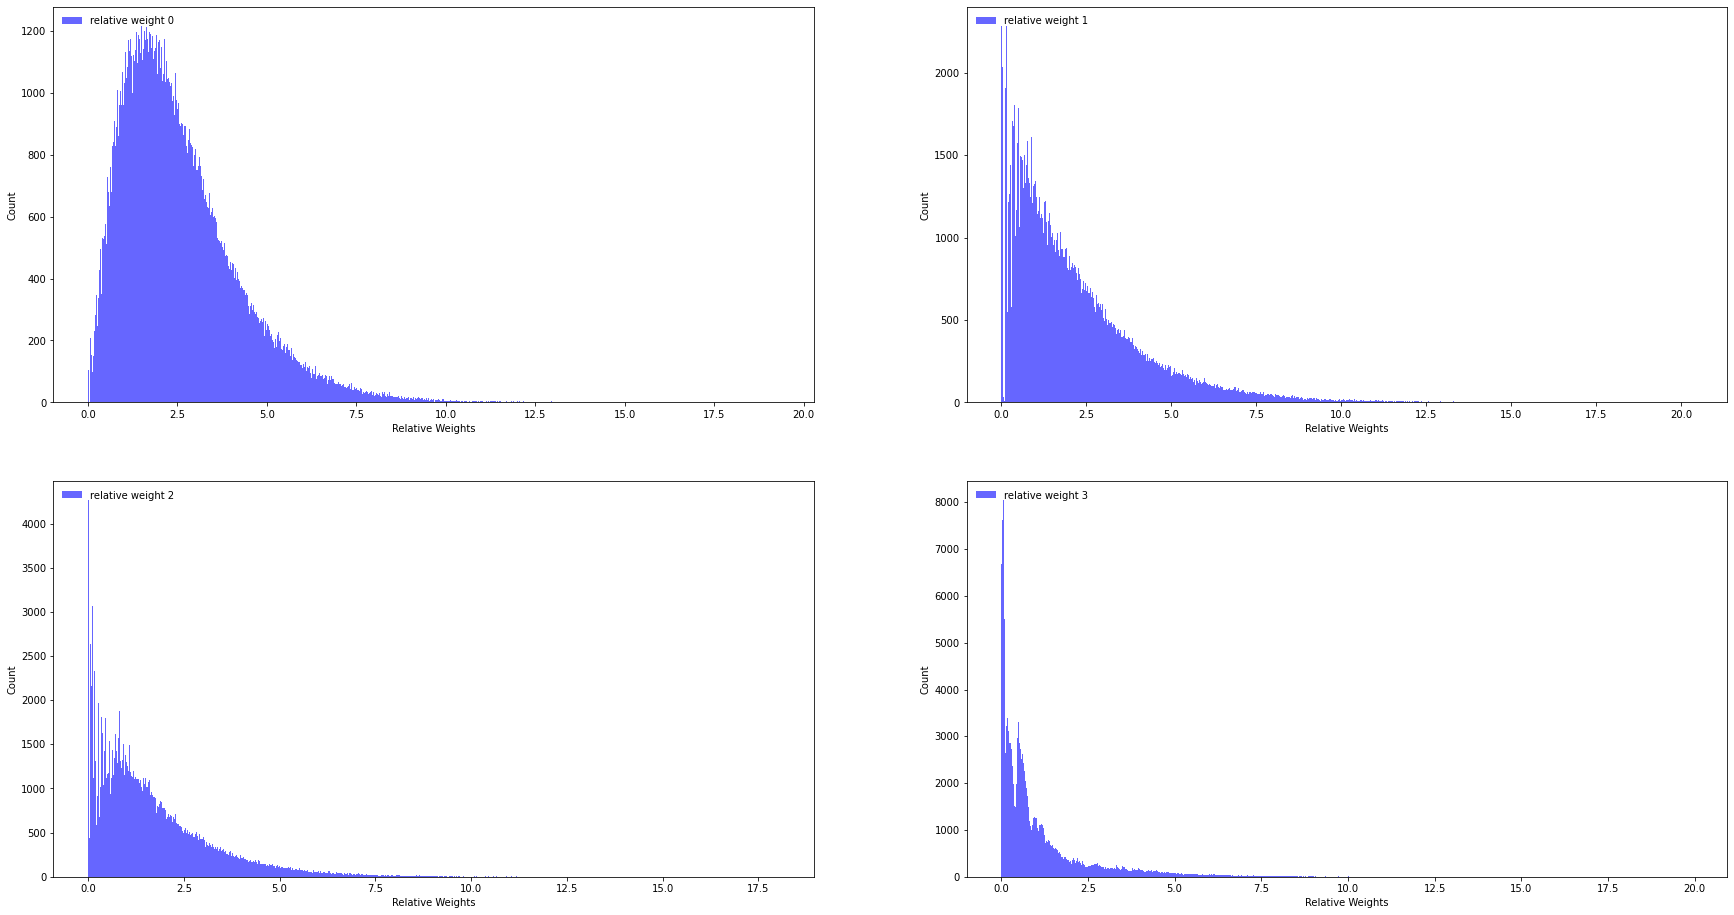

In [47]:
# Generically define how many plots along and across
ncols = 2
# nrows = int(np.ceil(len(rough.iloc[:,:4].columns) / (1.0*ncols)))
fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(30, 16))

# Lazy counter so we can remove unwated axes
counter = 0
for i in range(2):
    for j in range(ncols):

        ax = axes[i][j] # axes[i][j] # i is incase of adding more than one row for displaying columns

        # Plot when we have data
        if counter < len(rough.iloc[:,:4].columns):

            ax.hist(rough.iloc[:,:4][rough.iloc[:,:4].columns[counter]], bins=700, color='blue', alpha=0.6, label='{}'.format(rough.iloc[:,:4].columns[counter]))
            ax.set_xlabel('Relative Weights')
            ax.set_ylabel('Count')
            # ax.set_ylim([0, 5])
            leg = ax.legend(loc='upper left')
            leg.draw_frame(False)

        # Remove axis when we no longer have data
        else:
            ax.set_axis_off()

        counter += 1

plt.show()

### Create a word cloud with calculated association strength (idf * relative weights)

In [4]:
df_f = pd.read_csv('../data/final_x_idf.csv')
df_f = df_f.iloc[:,1:]


In [5]:
ltc_dic = pd.Series(df_f['relative weight 3'].values,index=df_f.MLTC).to_dict()
ltc_dic

{'ADHD': 3.247032520068312,
 'BAD': 2.1068853004179413,
 'BPH': 0.000627279419637,
 'CCD': 0.0073987962023856,
 'CHD': 0.290163577771149,
 'CKD': 0.4411585869916681,
 'COPD': 0.0830107409310007,
 'ESRD': 1.0794231377212622,
 'GCA': 0.0917273102754971,
 'GN': 0.024322417771624,
 'GORD': 0.0002826401938645,
 'Intracereb_haem': 0.0304783473141996,
 'MDS': 0.1403983596605738,
 'MND': 0.2116052129408753,
 'NAFLD_NASH': 1.1604051955884889,
 'NHL': 0.0197240498747259,
 'OA': 0.0350912914471918,
 'PCOS': 0.0141590941064073,
 'PCV': 0.0987292445825854,
 'PD': 0.1580753070657441,
 'PMR': 0.0155532282069127,
 'PSA': 2.2026759944879637,
 'PTSD': 0.0004810944562921,
 'RhA': 0.0606296198532981,
 'Rh_valve': 0.0390760799570202,
 'SARS_CoV2': 2.538520153922294,
 'SLE': 0.0736207048357154,
 'SVT': 0.0102440589106724,
 'Subarach': 0.0329361354444472,
 'TB': 0.3868443819565905,
 'adrenal_insufficiency': 1.4211965043454642,
 'alcohol_depend': 0.408685770046281,
 'allergic_rhinitis': 0.0002408146289704,
 '

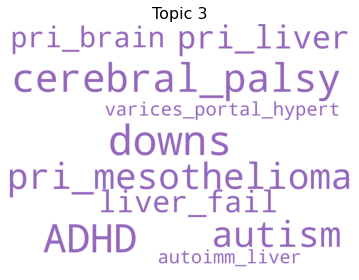

In [7]:
# Wordcloud of Top N LTCs for each topic

# Change the 'topics' variable with the name of the topic you want to generate the wordcloud for, 
# But should be same as the dictionary generated using earlier code
i = 4
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = df_f[['relative weight 3']] # Since we have fixed the topics to 4, we can change this to make it dynamic

if i < 9:
    # fig.add_subplot(ax)
    topic_words = ltc_dic
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic 3', fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
# fig.savefig("../images/topic0_relative_weight.png", dpi=60)

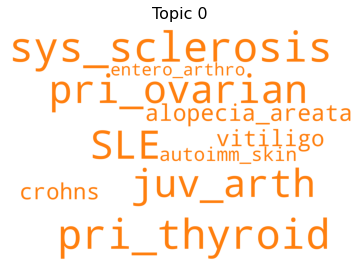

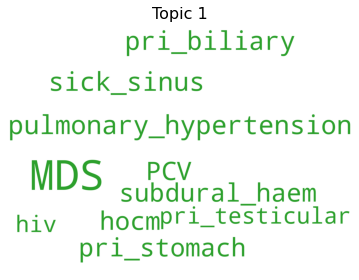

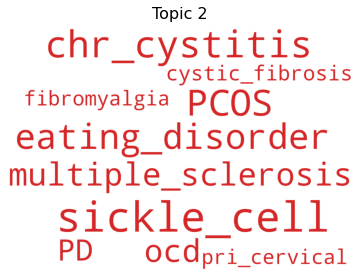

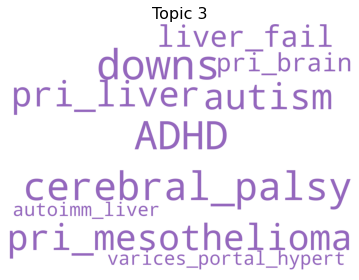

In [27]:
# Wordcloud of Top N LTCs for each topic based on association strength

i = 1
for j in df_f.columns[6:10]:

    ltc_dic = pd.Series(df_f[j].values,index=df_f.MLTC).to_dict()

    colrs = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    cloud = WordCloud(background_color='white',
                    width=2500,
                    height=1800,
                    max_words=10,
                    colormap='tab10',
                    color_func=lambda *args, **kwargs: colrs[i],
                    prefer_horizontal=1.0)

    topics = df_f[[j]] # Since we have fixed the topics to 4, we can change this to make it dynamic

    if i < 9:
        # fig.add_subplot(ax)
        topic_words = ltc_dic
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        titl = 'Topic ' + str(j[-1])
        plt.gca().set_title(titl, fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()
    i = i+1
# fig.savefig("../images/topic0_relative_weight.png", dpi=60)

### Colllect top 10 percentile of association strength aand finding all the counts of the diseases present to generate a bar chart

In [154]:
df_res = pd.read_csv('../data/Results.csv')
df_res = rough.copy()
df_res

relative weight 0  relative weight 1  relative weight 2  \
0                2.144746           1.457247           0.072923   
1                1.225088           2.624203           1.751945   
2                3.618626          12.423768           0.725964   
3                2.032642           1.227259           1.960756   
4                0.742128           3.094319           0.178789   
...                   ...                ...                ...   
143163           3.691600           1.737201           4.255927   
143164           0.258023           2.533009           0.820930   
143165           3.148057           2.969476           0.009075   
143166           1.343660           0.401718           2.732813   
143167           2.452814           0.599391           0.159047   

        relative weight 3                                    patient_disease  
0                0.514877  [dermatitis, erectile_dysfunction, OA, pri_ski...  
1                2.569705  [female_genital_prolapse, fracture_hip, obesit...  
2                2.553370  [pri_skin, allergic_rhinitis, atrial_fibrilati...  
3                0.570672  [OA, enthesopathy, hypertension, thyroid, cons...  
4                0.073663                  [OA, pri_skin, enthesopathy, CCD]  
...                   ...                                                ...  
143163           0.163548  [dermatitis, urine_incont, allergic_rhinitis, ...  
143164           0.785093  [depression, cerebrovascular_dz, anxiety_phobi...  
143165           1.995343  [hypertension, CCD, vitb12_deficiency, iron_de...  
143166           1.857038  [obesity, allergic_rhinitis, depression, PTSD,...  
143167           0.455733  [dermatitis, skin_ulcer, enthesopathy, alcohol...  

[143168 rows x 5 columns]

Column:  relative weight 0 :  4.8098090457
[('dermatitis', 8463), ('enthesopathy', 7256), ('sinusitis', 6912), ('depression', 6571), ('allergic_rhinitis', 6561), ('OA', 6209), ('hypertension', 6026), ('asthma', 4808), ('oth_anaemia', 4741), ('anxiety_phobia', 4184)] 

Column:  relative weight 1 :  4.8371097182


C:\Users\Acer\AppData\Local\Temp\ipykernel_4636\2028420127.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[('hypertension', 8391), ('enthesopathy', 6077), ('OA', 5737), ('CHD', 4987), ('dermatitis', 4820), ('depression', 4763), ('hearing_loss', 3965), ('erectile_dysfunction', 3959), ('atrial_fibrilation', 3574), ('CKD', 3510)] 

Column:  relative weight 2 :  3.7776551757


C:\Users\Acer\AppData\Local\Temp\ipykernel_4636\2028420127.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[('depression', 9175), ('enthesopathy', 7107), ('anxiety_phobia', 6588), ('dermatitis', 6059), ('sinusitis', 5497), ('irritable_bowel_syndrome', 5383), ('OA', 5213), ('GORD', 5019), ('migraine', 4893), ('hypertension', 4664)] 

Column:  relative weight 3 :  3.0285098692


C:\Users\Acer\AppData\Local\Temp\ipykernel_4636\2028420127.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[('type_2_diabetes', 9626), ('hypertension', 8930), ('unspecified_rare_diabetes', 8710), ('diab_eye', 6870), ('enthesopathy', 5560), ('depression', 5491), ('obesity', 4718), ('OA', 4717), ('dermatitis', 4519), ('erectile_dysfunction', 4402)] 



C:\Users\Acer\AppData\Local\Temp\ipykernel_4636\2028420127.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


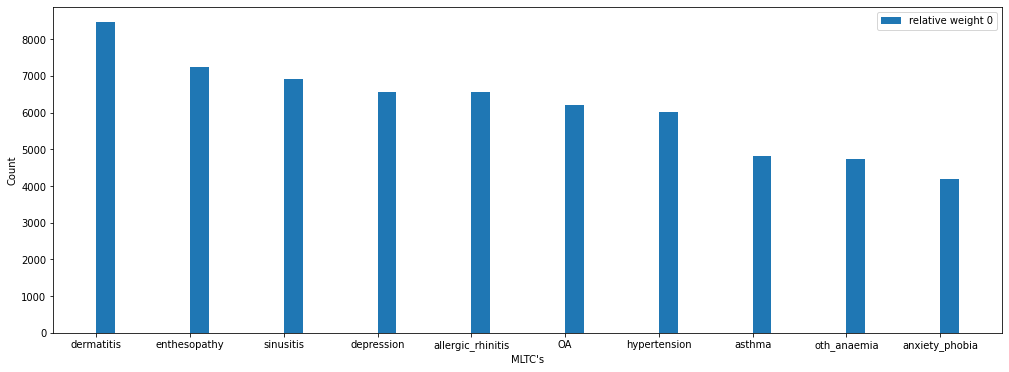

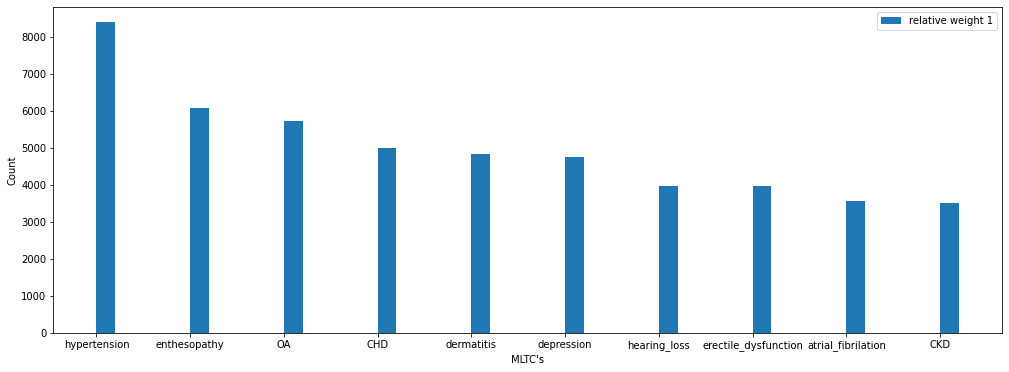

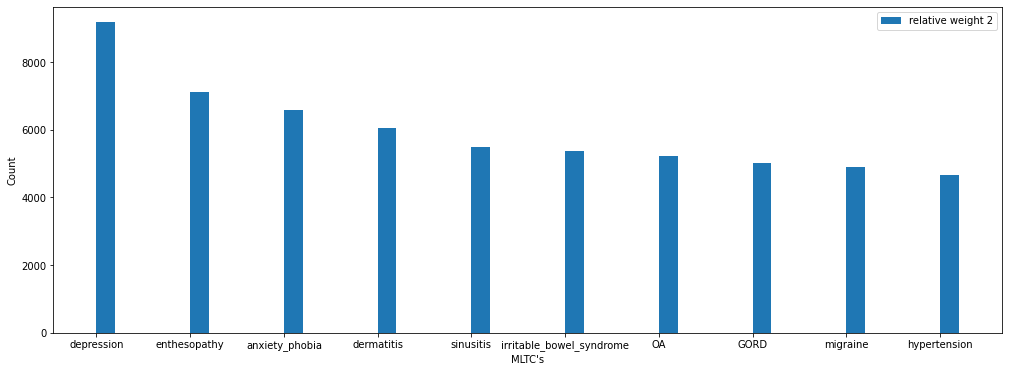

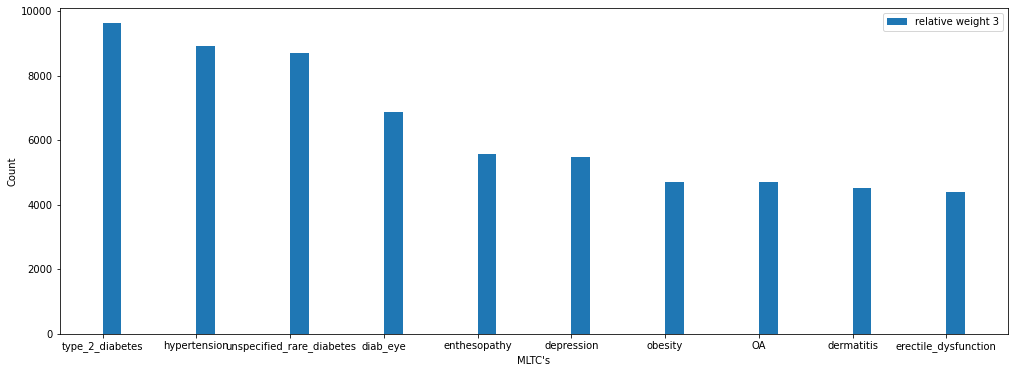

In [184]:
for i in df_res.iloc[:,:4].columns:
    prcntile = np.percentile(df_res[i], 90)
    print('Column: ', i ,': ' , prcntile)
    
    # ------------------------------------------------------------------------------------------
    
    counter_obj2 = Counter()
    for patient in list(df_res['patient_disease'][df_res[i] >= prcntile]):

        counter_obj2 += Counter(patient)
    
    print(counter_obj2.most_common(10), '\n')
    
    
    # ------------------------------------------------------------------------------------------
    
    
    A = dict(counter_obj2.most_common(10))

    fig, (ax1) = plt.subplots(figsize=(17,6))

    ax1.bar(A.keys(), A.values(), width=0.2, align='edge', label=i)
    # ax1.bar(B.keys(), B.values(), width=-0.2, align='edge', label='B')
    # ax1.set_xticks([2018, 2019])
    ax1.set_xlabel('MLTC\'s')
    ax1.set_ylabel('Count')
    ax1.legend()

    fig.show()

# 5) Hyperparameter Tuning

In [32]:
def lda_hyperparameter_tuning(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k,
                                           workers=3,
                                           random_state=100,
                                           chunksize=500,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=list_of_patients, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 4
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.linspace(0, 1, 5))
alpha.pop(0)
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.linspace(0, 1, 5))
beta.pop(0)
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               #gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# iterate through validation corpuses: 1
for i in range(len(corpus_sets)):
    # iterate through number of topics: 11
    for k in tqdm(topics_range):
        # iterate through alpha values: 6
        for a in alpha:
            # iterare through beta values: 5
            for b in beta:
                # get the coherence score for the given parameters
                cv = lda_hyperparameter_tuning(corpus=corpus_sets[i], dictionary=id2word, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Validation_Set'].append(corpus_title[i])
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)

pd.DataFrame(model_results).to_csv('../data/lda_tuning_results.csv', index=False)

In [16]:
model_tuning = pd.read_csv('../data/lda_tuning_results.csv')

sorted_model_tuning = model_tuning.sort_values(axis=0, by=['Coherence'], ascending=False, inplace=False)

len(sorted_model_tuning)
sorted_model_tuning.head(20)

Validation_Set  Topics       Alpha       Beta  Coherence
58      75% Corpus       5  asymmetric        1.0   0.449498
26      75% Corpus       4  asymmetric        0.5   0.448889
28      75% Corpus       4  asymmetric        1.0   0.447993
29      75% Corpus       4  asymmetric  symmetric   0.446923
27      75% Corpus       4  asymmetric       0.75   0.443063
25      75% Corpus       4  asymmetric       0.25   0.442410
57      75% Corpus       5  asymmetric       0.75   0.441327
56      75% Corpus       5  asymmetric        0.5   0.439692
59      75% Corpus       5  asymmetric  symmetric   0.436586
55      75% Corpus       5  asymmetric       0.25   0.433548
43      75% Corpus       5        0.75        1.0   0.421547
88      75% Corpus       6  asymmetric        1.0   0.420492
13      75% Corpus       4        0.75        1.0   0.419050
47      75% Corpus       5         1.0       0.75   0.416188
107     75% Corpus       7         1.0       0.75   0.415656
108     75% Corpus       7         1.0        1.0   0.415347
6       75% Corpus       4         0.5        0.5   0.415338
44      75% Corpus       5        0.75  symmetric   0.414945
147     75% Corpus       8  asymmetric       0.75   0.414870
39      75% Corpus       5         0.5  symmetric   0.413914

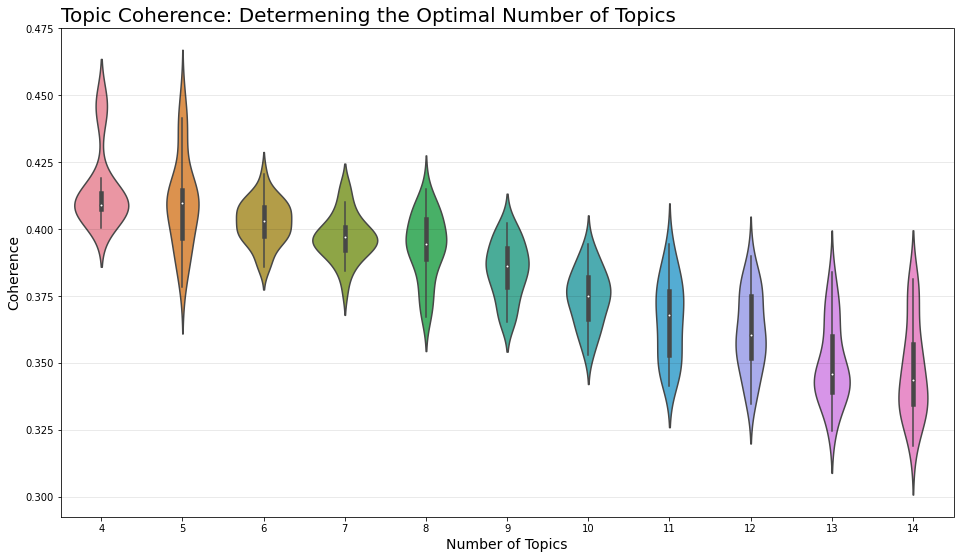

In [17]:
fig, ax = plt.subplots(figsize=(16,9))
sns.violinplot(ax=ax, data=model_tuning, x='Topics', y='Coherence')
ax.set_xlabel('Number of Topics', fontsize=14)
ax.set_ylabel('Coherence', fontsize=14)
ax.set_title('Topic Coherence: Determening the Optimal Number of Topics', loc='left', fontsize=20)
ax.yaxis.grid(color='black', which='both', alpha=0.1)
fig.savefig("../images/Violin Plot of Topic Coherence Scores.png", dpi=60)

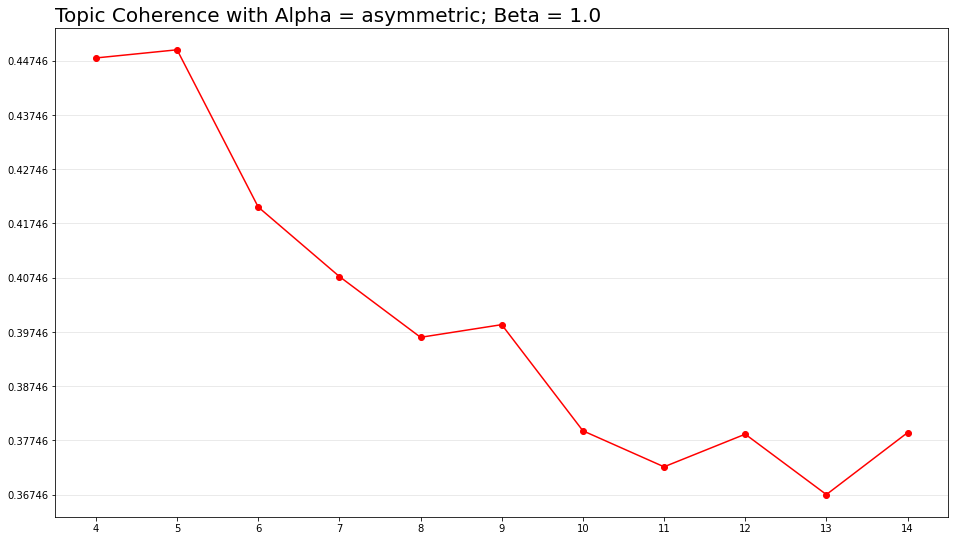

In [18]:
alpha = 'asymmetric'
beta = '1.0'
corpus = '75% Corpus'

filtered_model_tuning = model_tuning[(model_tuning['Alpha'] == alpha) 
                    & (model_tuning['Beta'] == beta)
                    & (model_tuning['Validation_Set'] == corpus)]

x = filtered_model_tuning['Topics']
y = filtered_model_tuning['Coherence']

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(x, y, color='red', marker='o')
ax.set_title('Topic Coherence with Alpha = {a}; Beta = {b}'.format(a=alpha, b=beta), loc='left', fontsize=20)
ax.set_yticks(np.arange(min(y), max(y), 0.01))
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
ax.yaxis.grid(color='black', which='both', alpha=0.1)


In [19]:
top_hyperp = model_tuning[(model_tuning['Topics']==4) & (model_tuning['Validation_Set']=='100% Corpus')]
top_hyperp.sort_values(axis=0, by=['Coherence'], ascending=False, inplace=True)
top_hyperp.head()

C:\Users\Acer\AppData\Local\Temp\ipykernel_7676\3248243186.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_hyperp.sort_values(axis=0, by=['Coherence'], ascending=False, inplace=True)


Empty DataFrame
Columns: [Validation_Set, Topics, Alpha, Beta, Coherence]
Index: []

# 6) Visualizing LDA Model

In [20]:
pp.pprint(lda_model.print_topics())

[   (   0,
        '0.086*"dermatitis" + 0.062*"enthesopathy" + 0.060*"sinusitis" + '
        '0.058*"allergic_rhinitis" + 0.046*"OA" + 0.044*"hypertension" + '
        '0.041*"depression" + 0.039*"asthma" + 0.030*"thyroid" + '
        '0.029*"hearing_loss"'),
    (   1,
        '0.086*"hypertension" + 0.052*"CHD" + 0.048*"erectile_dysfunction" + '
        '0.048*"enthesopathy" + 0.048*"OA" + 0.035*"BPH" + 0.035*"gout" + '
        '0.034*"hearing_loss" + 0.031*"atrial_fibrilation" + 0.029*"GORD"'),
    (   2,
        '0.101*"depression" + 0.091*"irritable_bowel_syndrome" + '
        '0.087*"anxiety_phobia" + 0.056*"GORD" + 0.049*"somatoform" + '
        '0.048*"PTSD" + 0.046*"migraine" + 0.045*"oesoph_ulc" + '
        '0.043*"enthesopathy" + 0.034*"menorrhagia"'),
    (   3,
        '0.213*"type_2_diabetes" + 0.132*"unspecified_rare_diabetes" + '
        '0.093*"diab_eye" + 0.088*"hypertension" + 0.059*"obesity" + '
        '0.047*"erectile_dysfunction" + 0.026*"CKD" + 0.024*"depressio

In [46]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

c:\Users\Acer\OneDrive - Newcastle University\Work\CSC8639 - Thesis\MLTC-clustering-main\mltc\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.163568 -0.152351       1        1  50.195819
1     -0.165318  0.157992       2        1  24.855653
2      0.129023 -0.274218       3        1  16.595279
3      0.199863  0.268577       4        1   8.353249, topic_info=                          Term          Freq         Total Category  logprob  \
9              type_2_diabetes  19619.000000  19619.000000  Default  30.0000   
22                hypertension  56284.000000  56284.000000  Default  29.0000   
1                   dermatitis  47756.000000  47756.000000  Default  28.0000   
10   unspecified_rare_diabetes  12149.000000  12149.000000  Default  27.0000   
43    irritable_bowel_syndrome  16763.000000  16763.000000  Default  26.0000   
..                         ...           ...           ...      ...      ...   
24                     thyroid   1191.423994  17744.447452   Topic4  -4.3495   
104                  blindness    380.555768   1749.546848   Topic4  -5.4908   
18                enthesopathy   1111.253685  56466.458460   Topic4  -4.4192   
0                           OA    710.239133  42451.155199   Topic4  -4.8668   
36        gastritis_duodenitis    414.861811  17755.622873   Topic4  -5.4045   

     loglift  
9    30.0000  
22   29.0000  
1    28.0000  
10   27.0000  
43   26.0000  
..       ...  
24   -0.2184  
104   0.9570  
18   -1.4456  
0    -1.6080  
36   -1.2740  

[218 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
198       1  0.010239               ADHD
198       2  0.010239               ADHD
198       3  0.010239               ADHD
198       4  0.962439               ADHD
128       1  0.000831                BAD
...     ...       ...                ...
50        4  0.361683  vitb12_deficiency
135       1  0.987721           vitiligo
135       2  0.002786           vitiligo
135       3  0.002786           vitiligo
135       4  0.006966           vitiligo

[576 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

In [22]:
x=lda_model.show_topics(num_topics=4, num_words=40, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Topics and Words
for topic,words in topics_words:
    pp.pprint(str(topic)+ "::"+ str(words)+ ":: length: {n}".format(n=len(words)))
print()

# #Below Code Prints Only Words 
# for topic,words in topics_words:
#     pp.pprint(" ".join(words))

("0::['dermatitis', 'enthesopathy', 'sinusitis', 'allergic_rhinitis', 'OA', "
 "'hypertension', 'depression', 'asthma', 'thyroid', 'hearing_loss', "
 "'venous_lymphatic', 'anxiety_phobia', 'seb_derm', 'oth_anaemia', "
 "'skin_ulcer', 'migraine', 'osteoporosis', 'obesity', 'PTSD', "
 "'iron_deficiency_anaemia', 'spondylosis', 'menorrhagia', 'rosacea', "
 "'urine_incont', 'constipation_read', 'urticaria', 'female_genital_prolapse', "
 "'GORD', 'tinnitus', 'psoriasis', 'diverticular', 'gastritis_duodenitis', "
 "'pri_skin', 'intervert_disc', 'alcohol_depend', 'pri_breast', "
 "'cin_cervical', 'nasal_polyp', 'CKD', 'vitb12_deficiency']:: length: 40")
("1::['hypertension', 'CHD', 'erectile_dysfunction', 'enthesopathy', 'OA', "
 "'BPH', 'gout', 'hearing_loss', 'atrial_fibrilation', 'GORD', 'CKD', "
 "'cerebrovascular_dz', 'gastritis_duodenitis', 'oesoph_ulc', 'diverticular', "
 "'alcohol_depend', 'urolithiasis', 'spondylosis', 'pri_skin', 'ulcer_peptic', "
 "'obesity', 'heart_valve_dz', 'pri

In [47]:
def find_dominant_topics(ldamodel=None, corpus=corpus, texts=list_of_patients):
    
    dom_topics = pd.DataFrame()

    # Get main topic for each patient
    for i, row_list in enumerate(ldamodel[corpus]):
        
        if ldamodel.per_word_topics:
            row = row_list[0]
        else:
            row = row_list
        #print(row)
        
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each patient
        for j, (topic_num, prop_topic) in enumerate(row):
            
            # If dominant topic
            if j == 0:
                
                wp = ldamodel.show_topic(topic_num)
                
                topic_keywords = ", ".join([word for word, prop in wp])
                
                dom_topics = dom_topics.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
                
    dom_topics.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original patient record to the end of the output
    contents = pd.Series(texts)
    dom_topics = pd.concat([dom_topics, contents], axis=1)
    
    return dom_topics


temp = find_dominant_topics(ldamodel=lda_model, corpus=corpus, texts=list_of_patients)

# Format
dominant_patient_topics = temp.reset_index()
dominant_patient_topics.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
dominant_patient_topics.head(10)

C:\Users\Acer\AppData\Local\Temp\ipykernel_7676\1077547232.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topics = dom_topics.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\Acer\AppData\Local\Temp\ipykernel_7676\1077547232.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topics = dom_topics.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0               0              0.5817   
1            1               3              0.3661   
2            2               1              0.7507   
3            3               0              0.9294   
4            4               1              0.8327   
5            5               0              0.8745   
6            6               3              0.6958   
7            7               3              0.4679   
8            8               0              0.6417   
9            9               0              0.8966   

                                            Keywords  \
0  dermatitis, enthesopathy, sinusitis, allergic_...   
1  type_2_diabetes, unspecified_rare_diabetes, di...   
2  hypertension, CHD, erectile_dysfunction, enthe...   
3  dermatitis, enthesopathy, sinusitis, allergic_...   
4  hypertension, CHD, erectile_dysfunction, enthe...   
5  dermatitis, enthesopathy, sinusitis, allergic_...   
6  type_2_diabetes, unspecified_rare_diabetes, di...   
7  type_2_diabetes, unspecified_rare_diabetes, di...   
8  dermatitis, enthesopathy, sinusitis, allergic_...   
9  dermatitis, enthesopathy, sinusitis, allergic_...   

                                                Text  
0  [dermatitis, erectile_dysfunction, OA, pri_ski...  
1  [female_genital_prolapse, fracture_hip, obesit...  
2  [pri_skin, allergic_rhinitis, atrial_fibrilati...  
3  [OA, enthesopathy, hypertension, thyroid, cons...  
4                  [OA, pri_skin, enthesopathy, CCD]  
5  [allergic_rhinitis, enthesopathy, hypertension...  
6  [erectile_dysfunction, type_2_diabetes, allerg...  
7  [erectile_dysfunction, pri_skin, type_2_diabet...  
8  [dermatitis, type_2_diabetes, enthesopathy, hy...  
9  [OA, allergic_rhinitis, menorrhagia, asthma, f...

In [ ]:
# dominant_patient_topics.to_csv('../data/dominant_patient_topics.csv')

In [48]:

pp.pprint(dominant_patient_topics.loc[0, 'Keywords'])
pp.pprint(dominant_patient_topics.loc[17, 'Keywords'])
pp.pprint(dominant_patient_topics.loc[1, 'Keywords'])
pp.pprint(dominant_patient_topics.loc[2, 'Keywords'])


('dermatitis, enthesopathy, sinusitis, allergic_rhinitis, OA, hypertension, '
 'depression, asthma, thyroid, hearing_loss')
('dermatitis, enthesopathy, sinusitis, allergic_rhinitis, OA, hypertension, '
 'depression, asthma, thyroid, hearing_loss')
('type_2_diabetes, unspecified_rare_diabetes, diab_eye, hypertension, obesity, '
 'erectile_dysfunction, CKD, depression, CHD, vitb12_deficiency')
('hypertension, CHD, erectile_dysfunction, enthesopathy, OA, BPH, gout, '
 'hearing_loss, atrial_fibrilation, GORD')


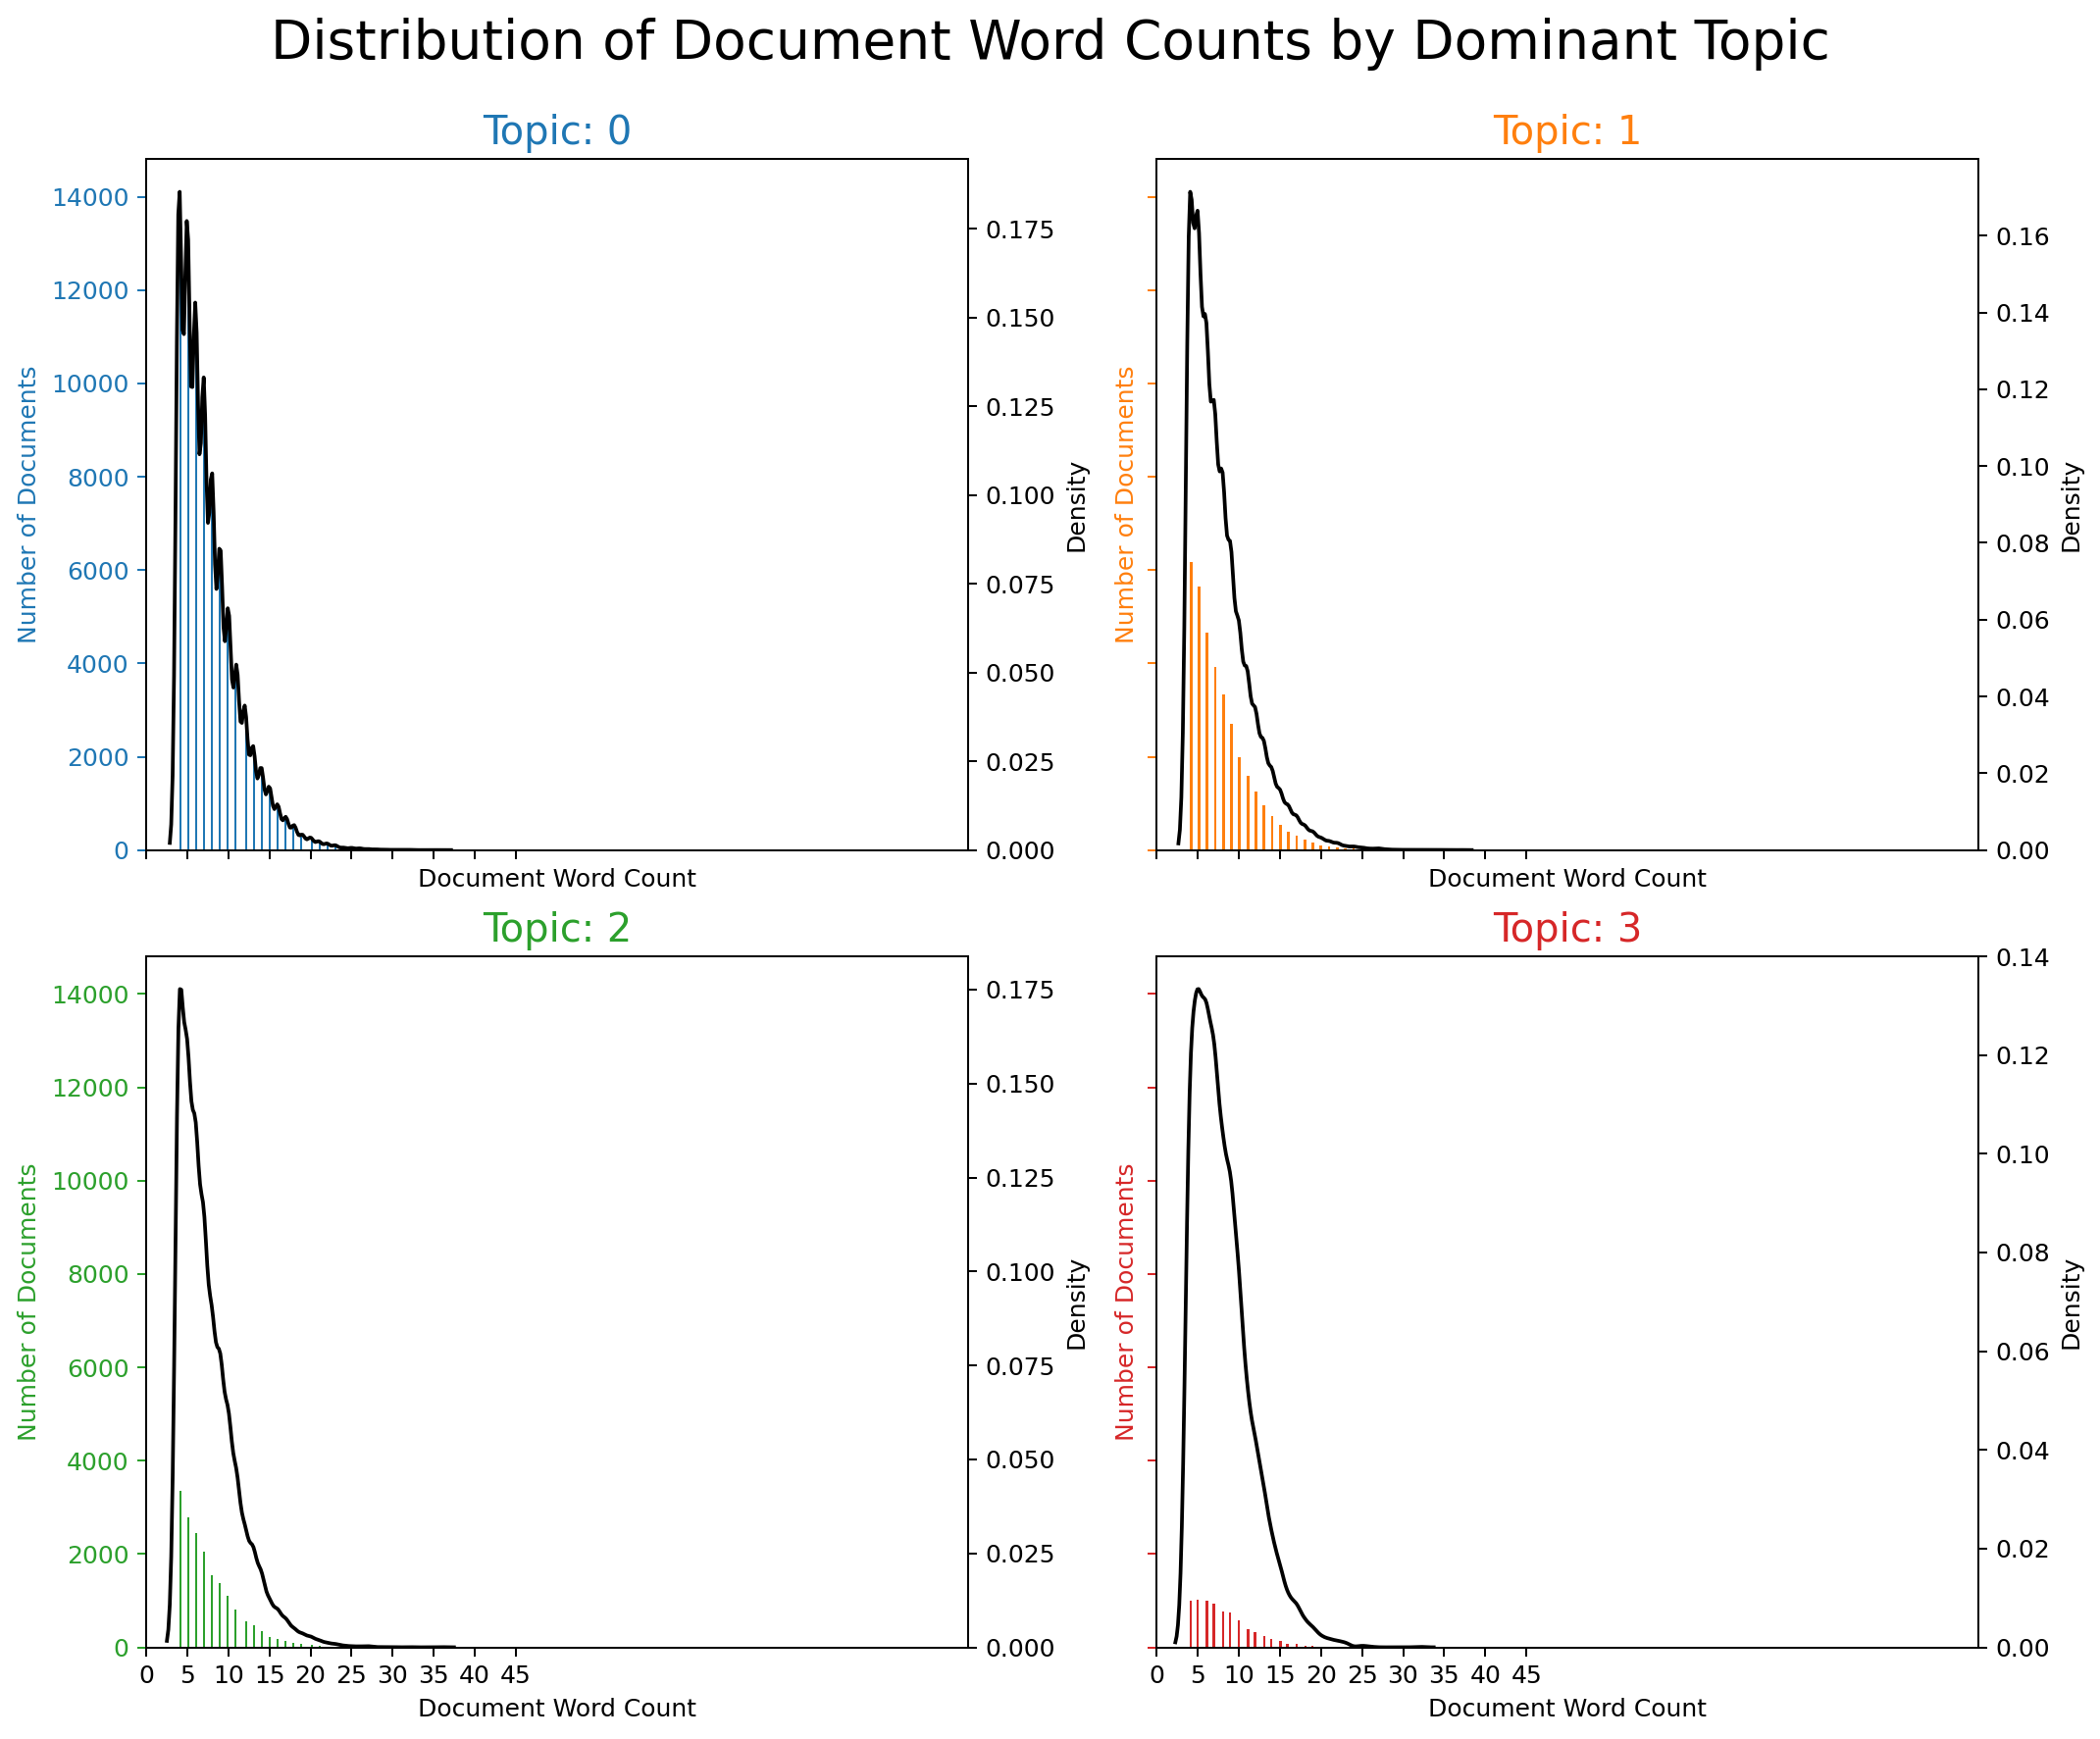

In [49]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(12,10), dpi=180, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = dominant_patient_topics.loc[dominant_patient_topics.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 100), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,45, 10), rotation = 'vertical' )
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

C:\Users\Acer\AppData\Local\Temp\ipykernel_7676\863801753.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\Acer\AppData\Local\Temp\ipykernel_7676\863801753.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\Acer\AppData\Local\Temp\ipykernel_7676\863801753.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\Acer\AppData\Local\Temp\ipykernel_7676\863801753.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


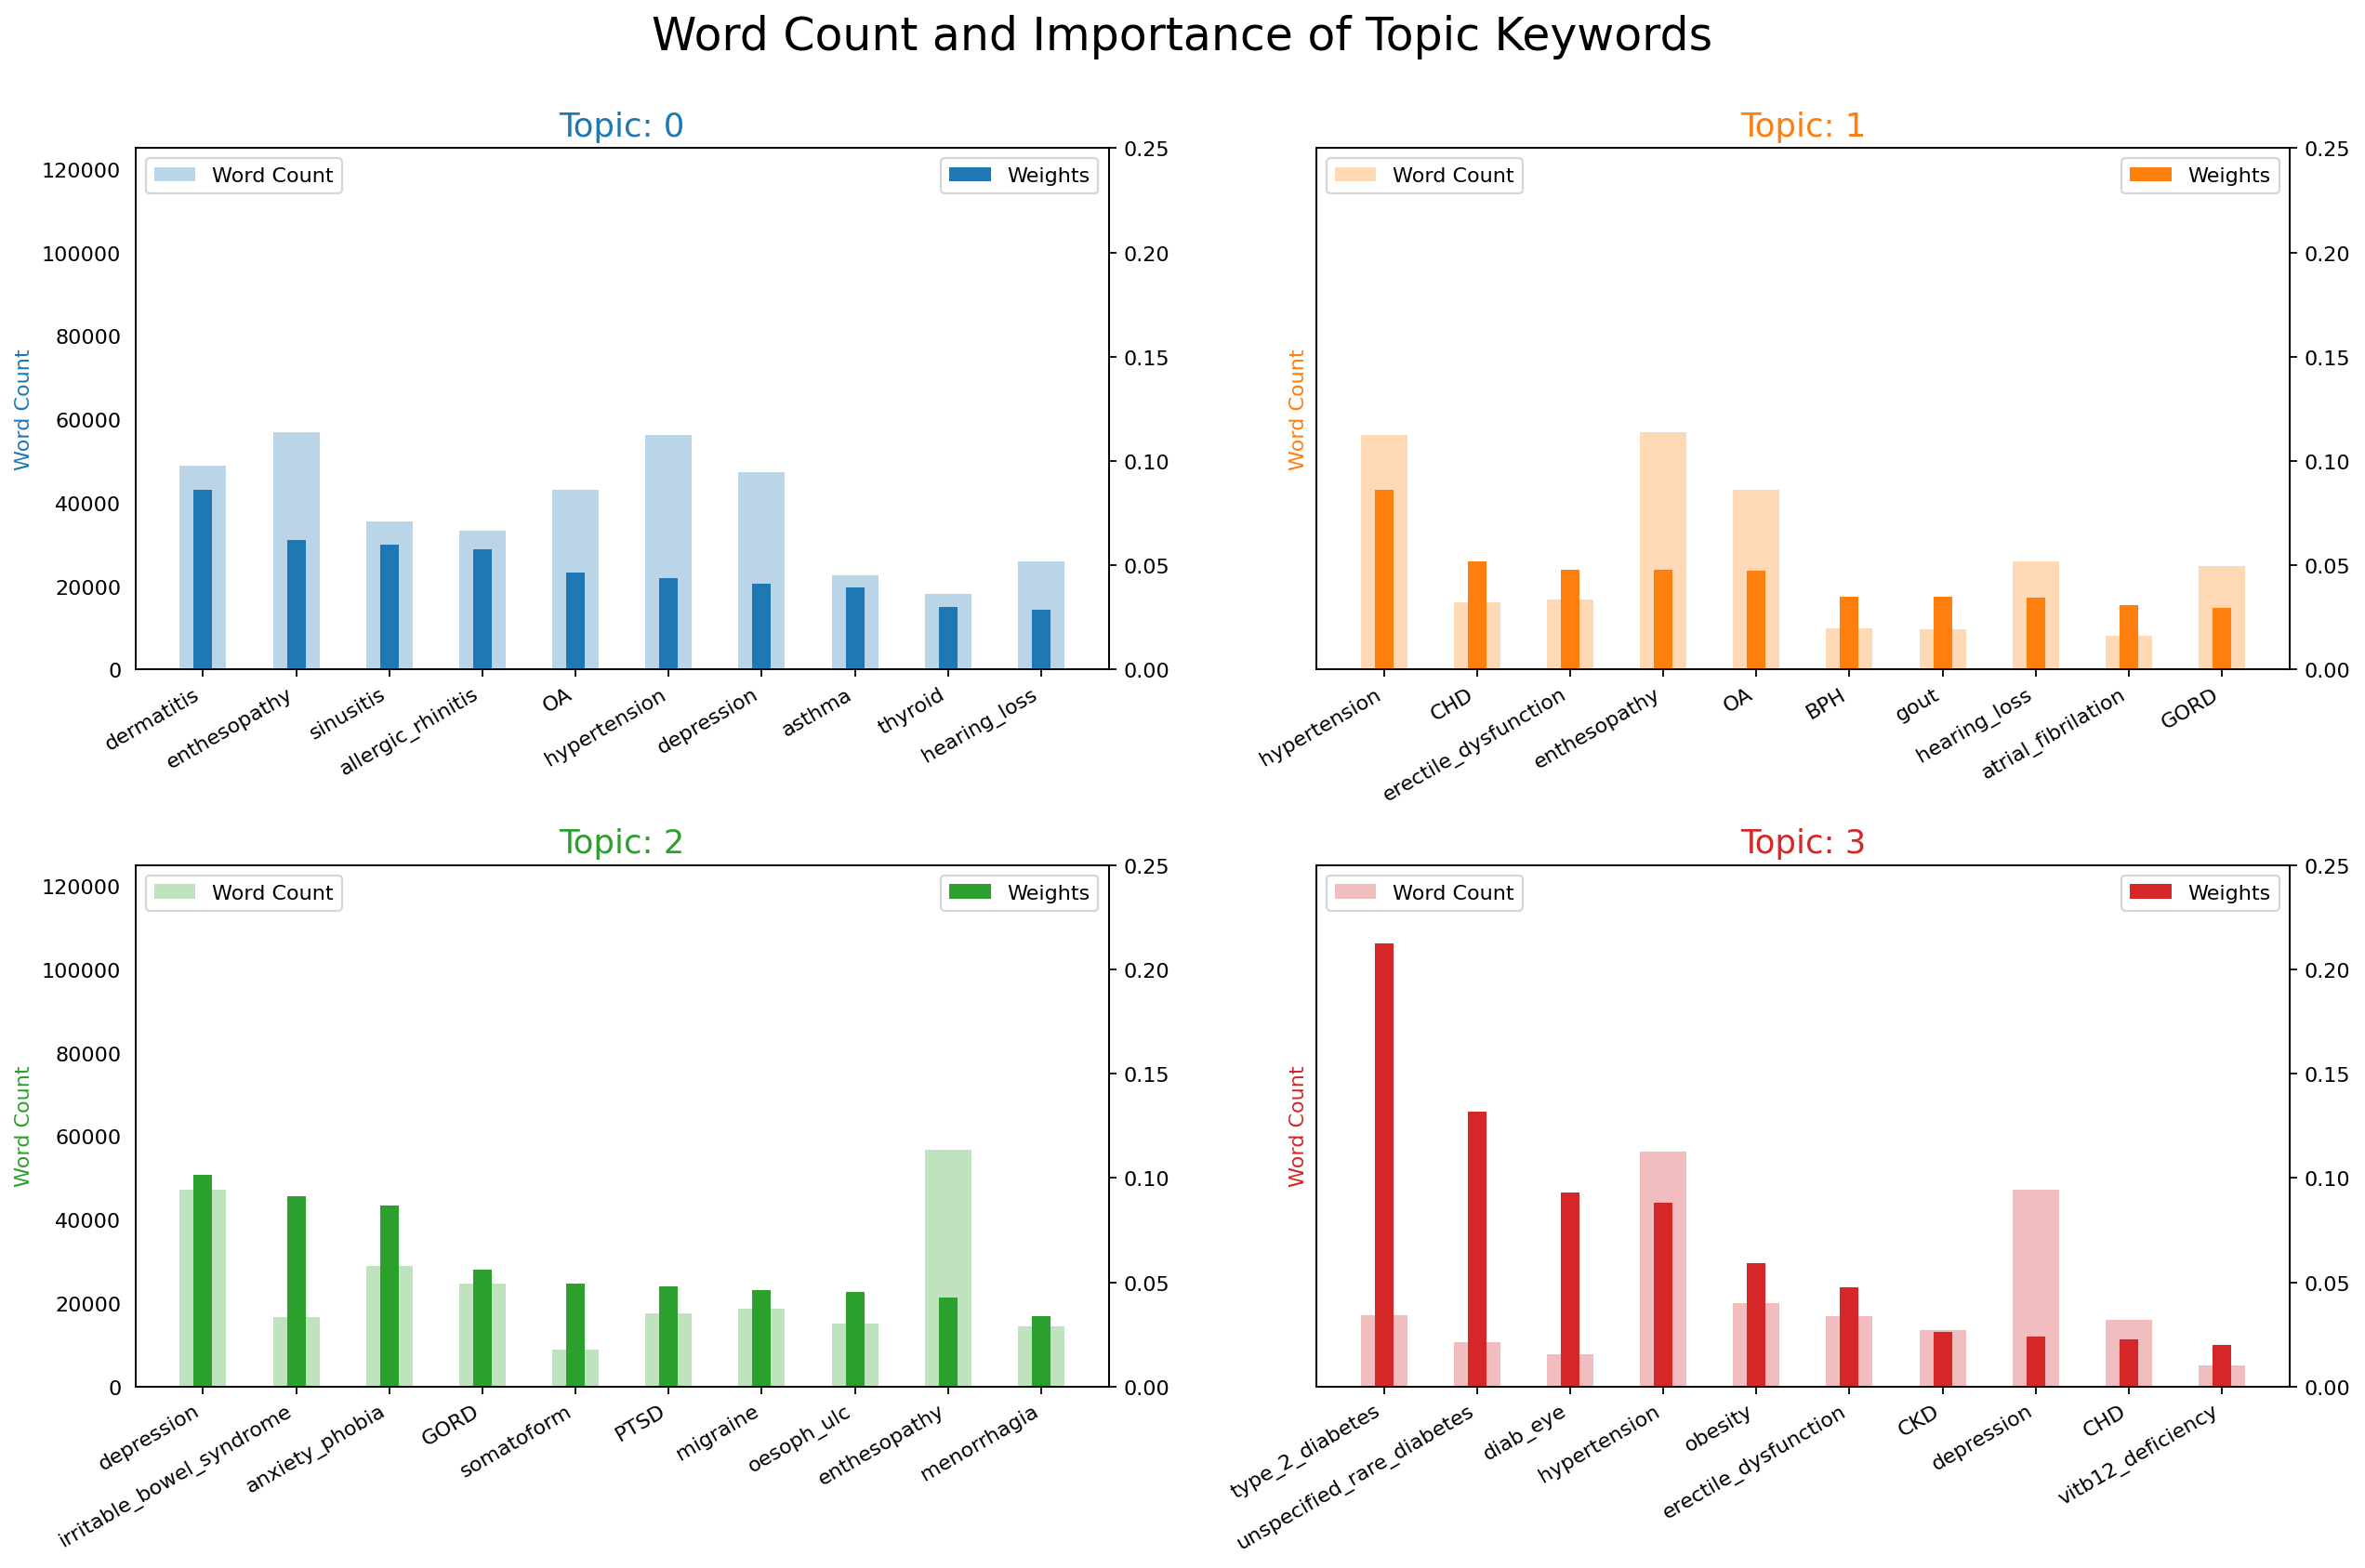

In [26]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
# data_flat = [w for w_list in data_ready for w in w_list]
# counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter_obj[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.25); ax.set_ylim(0, 125000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [50]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

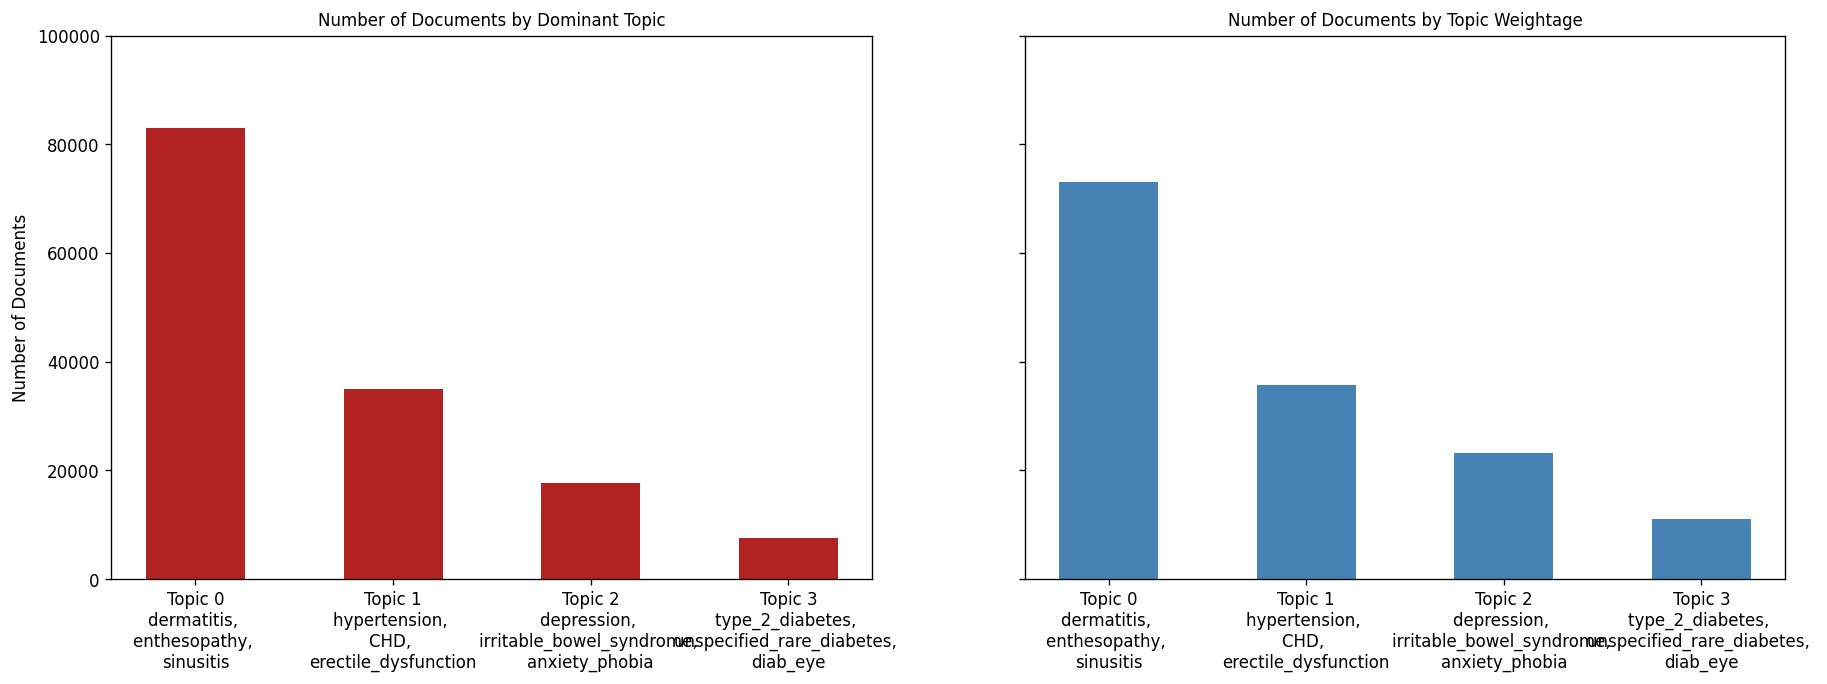

In [51]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 100000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [ ]:
# 8 Topics

# Wordcloud of Top N LTCs for each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(16,16), sharex=True, sharey=True)
axes[-1, -1].axis('off')

for i, ax in enumerate(axes.flatten()):
    if i < 9:
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
fig.savefig("../images/Optimized 8 Topics WordCloud.png", dpi=60)

In [ ]:
# 7 Topics

# Wordcloud of Top N LTCs for each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(16,16), sharex=True, sharey=True)
axes[-1, -1].axis('off')

for i, ax in enumerate(axes.flatten()):
    if i < 7:
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
fig.savefig("../images/Optimized 7 Topics WordCloud.png", dpi=60)

In [ ]:
# 6 Topics

# Wordcloud of Top N LTCs for each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(16,16), sharex=True, sharey=True)
axes[-1, -1].axis('off')

for i, ax in enumerate(axes.flatten()):
    if i < 7:
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
fig.savefig("../images/Optimized 6 Topics WordCloud.png", dpi=60)

In [ ]:
# 5 Topics

# Wordcloud of Top N LTCs for each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(16,16), sharex=True, sharey=True)
axes[-1, -1].axis('off')

for i, ax in enumerate(axes.flatten()):
    if i < 5:
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
fig.savefig("../images/Optimized 5 Topics WordCloud.png", dpi=60)

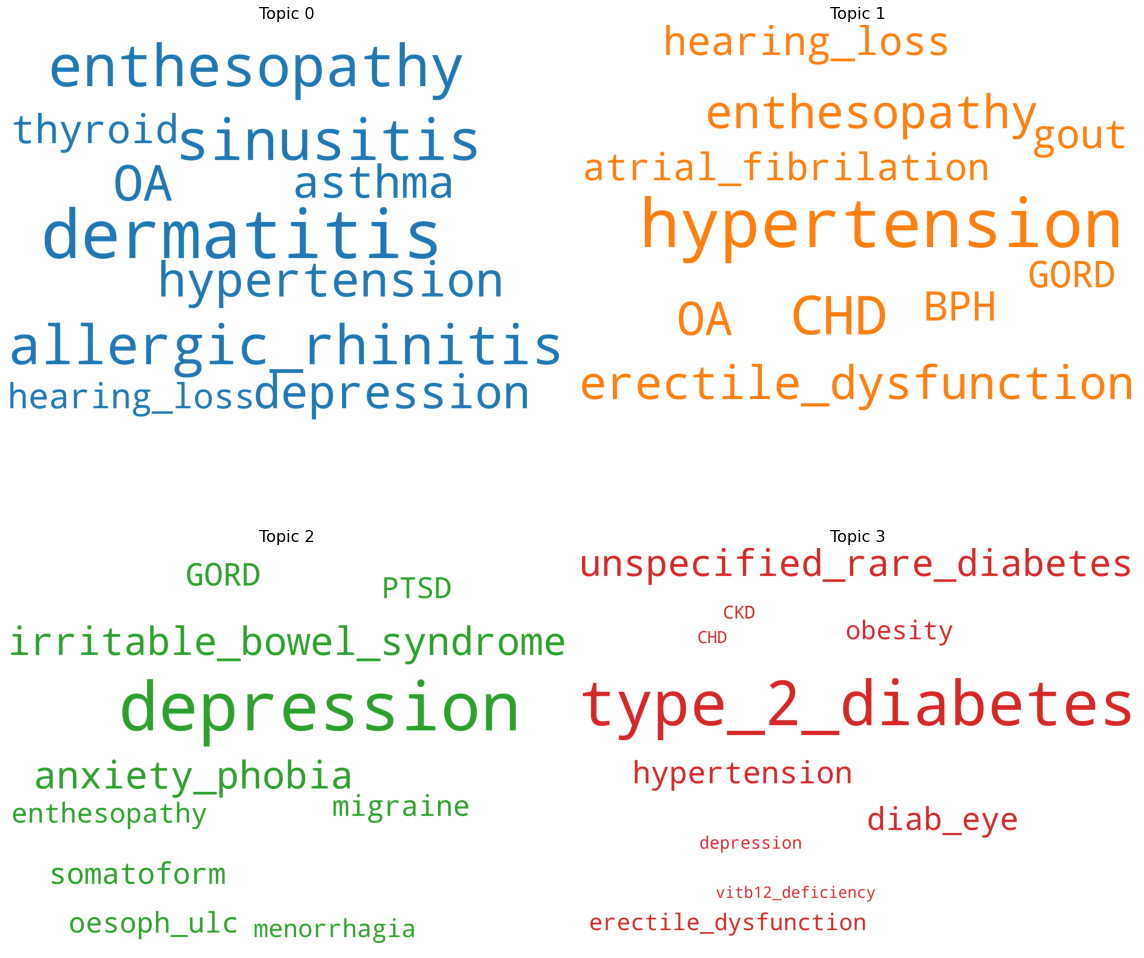

In [52]:
# 4 Topics

# Wordcloud of Top N LTCs for each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(16,16), sharex=True, sharey=True)
axes[-1, -1].axis('off')

for i, ax in enumerate(axes.flatten()):
    if i < 4:
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
fig.savefig("../images/Optimized 4 Topics WordCloud.png", dpi=60)

In [ ]:
test1 = lda_model[corpus]
for topic in test1:
    print(topic)

In [53]:
dominant_topic_weights = []

# Get topic weights
for i, row_list in enumerate(lda_model[corpus]):
    
    row_list.sort(reverse=True, key=lambda x: (x[1]))
    dominant_topic_weights.append(row_list[0])
    
    if i < 3:
        pp.pprint(i)
        pp.pprint(row_list)
        
for x in range(3):
        pp.pprint("Dominant Topics with Weights: {n}".format(n = dominant_topic_weights[x]))
        
# Array of topic weights    
arr = pd.DataFrame(dominant_topic_weights).fillna(0).values

# Keep the well-separated points
arr = arr[np.amax(arr, axis=1) > 0.40]

# for x in range(3):
#         pp.pprint("Original Array of Topic Weights: {n}".format(n = arr[x]))


# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, perplexity=50, random_state=0, angle=.19, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

0
[(0, 0.58173835), (1, 0.35963959), (2, 0.032523002), (3, 0.026099037)]
1
[(3, 0.36609685), (2, 0.34498304), (1, 0.22458895), (0, 0.064331144)]
2
[(1, 0.7506406), (0, 0.22734953), (2, 0.012234939)]
'Dominant Topics with Weights: (0, 0.58173835)'
'Dominant Topics with Weights: (3, 0.36609685)'
'Dominant Topics with Weights: (1, 0.7506406)'


c:\Users\Acer\OneDrive - Newcastle University\Work\CSC8639 - Thesis\MLTC-clustering-main\mltc\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\Acer\OneDrive - Newcastle University\Work\CSC8639 - Thesis\MLTC-clustering-main\mltc\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [54]:
len(tsne_lda[:,0])

141587

In [55]:
# from random import randint
# colors = []

# for i in range(20):
#     colors.append('#%06X' % randint(0, 0xFFFFFF))
    
# mycolors = np.array(colors)
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

output_notebook()
n_topics = 5

topic_num = [int(x[0]) for x in arr]
# topic_num = [int(a) for a in topic_num]
for x in range(3):
    pp.pprint("Dominant topic in each doc: {n}".format(n = topic_num[x]))

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], fill_alpha=0.2, color=mycolors[topic_num])

show(plot)

Loading BokehJS ...

'Dominant topic in each doc: 0'
'Dominant topic in each doc: 3'
'Dominant topic in each doc: 1'


In [56]:
for i in range (5):
    pp.pprint("Count for Dominant topic {i}: {n}".format(i=i, n = len(dominant_patient_topics[dominant_patient_topics['Dominant_Topic']==i])))

'Count for Dominant topic 0: 82961'
'Count for Dominant topic 1: 34979'
'Count for Dominant topic 2: 17676'
'Count for Dominant topic 3: 7552'
'Count for Dominant topic 4: 0'


In [ ]:
def Func(e):
    return e[1]

test = []
test_dom_topic = []

for i, row_list in enumerate(lda_model[corpus]):
    if i < 5:
        row_list.sort(reverse=True, key = lambda x: (x[1]))
        test.append(row_list[0])
    else:
        break
test_dom_topic = [x[0] for x in test]    
print(test)
print(test_dom_topic)